# Hybrid ML Trading Strategy with Stepwise Feature Selection

## Overfitting Mitigation Strategy:
1. **Bidirectional Stepwise Feature Selection**: Use BIC/AIC to select optimal features with Logistic Regression
2. **Tree-Based Feature Importance**: Rank and select top features from Random Forest
3. **Model Complexity Reduction**: Reduce n_estimators, max_depth, increase min_samples_split
4. **Cross-Validation**: TimeSeriesSplit to monitor train/validation gap
5. **Regularization**: Stronger penalties and class weights

## Current Problems Being Addressed:
- Training Accuracy: 100% (OVERFITTING)
- Test Accuracy: 54.2%
- Bull Regime Detection: Only 13.6% accuracy
- 110 features (likely many redundant/noisy)
- Train/Test performance gap: 45.8%

## Expected Improvements:
- Reduce feature count from 110 to 15-30 most predictive features
- Improve test set generalization
- Better Bull regime detection
- Lower train/test performance gap

## 1. Imports and Setup

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import os
import json

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, SelectFromModel

import scipy.stats as stats
from itertools import combinations

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

print("All imports successful")

All imports successful


## 2. Data Loading and Split

In [14]:
def load_and_split_dataset(train_ratio=0.3):
    """
    Load 1D momentum regime dataset and split chronologically
    """
    data_dir = '../data'
    filename = 'BTCUSD_2023_1min_enhanced_regimes_1D_momentum.csv'
    filepath = os.path.join(data_dir, filename)
    
    if not os.path.exists(filepath):
        print(f"Error: {filepath} not found")
        return None, None, None
    
    print("Loading 1D momentum regime dataset...")
    df = pd.read_csv(filepath)
    
    timestamp_col = 'timestamp' if 'timestamp' in df.columns else 'Timestamp'
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])
    df = df.set_index(timestamp_col).sort_index()
    
    cols_to_drop = [col for col in df.columns if 'Unnamed' in col]
    df = df.drop(columns=cols_to_drop)
    
    print(f"Dataset loaded: {df.shape}")
    print(f"Date range: {df.index.min()} to {df.index.max()}")
    
    split_idx = int(len(df) * train_ratio)
    train_df = df.iloc[:split_idx].copy()
    test_df = df.iloc[split_idx:].copy()
    
    print(f"\nTrain/Test Split (Chronological):")
    print(f"Training: {train_df.shape} ({train_ratio*100:.0f}%) | {train_df.index.min()} to {train_df.index.max()}")
    print(f"Testing:  {test_df.shape} ({(1-train_ratio)*100:.0f}%) | {test_df.index.min()} to {test_df.index.max()}")
    
    assert train_df.index.max() < test_df.index.min(), "Data leakage detected!"
    
    return train_df, test_df, df

train_df, test_df, full_df = load_and_split_dataset(train_ratio=0.7)

Loading 1D momentum regime dataset...
Dataset loaded: (434438, 33)
Date range: 2023-02-10 00:00:00 to 2023-12-31 14:27:00

Train/Test Split (Chronological):
Training: (304106, 33) (70%) | 2023-02-10 00:00:00 to 2023-09-28 14:20:00
Testing:  (130332, 33) (30%) | 2023-09-28 14:21:00 to 2023-12-31 14:27:00


## 3. Feature Engineering (Same as Original)

In [15]:
def engineer_ml_features(df, lookback_windows=[5, 10, 20, 50]):
    """
    Engineer comprehensive features for ML regime classification
    """
    df = df.copy()
    
    print("Engineering features for ML training...")
    
    # 1. Price-based features
    print("  - Price-based features")
    for window in lookback_windows:
        df[f'return_{window}d'] = df['Close'].pct_change(window)
        df[f'volatility_{window}d'] = df['Close'].pct_change().rolling(window).std()
        df[f'trend_strength_{window}d'] = (df['Close'] - df['Close'].shift(window)) / df['Close'].shift(window)
        
        if f'sma_{window}d' in df.columns:
            df[f'price_vs_sma_{window}d'] = (df['Close'] - df[f'sma_{window}d']) / df[f'sma_{window}d']
        if f'ema_{window}d' in df.columns:
            df[f'price_vs_ema_{window}d'] = (df['Close'] - df[f'ema_{window}d']) / df[f'ema_{window}d']
    
    # 2. Technical indicator features
    print("  - Technical indicator features")
    
    if 'rsi_14d' in df.columns:
        df['rsi_normalized'] = (df['rsi_14d'] - 50) / 50
        df['rsi_momentum'] = df['rsi_14d'].diff()
        df['rsi_oversold'] = (df['rsi_14d'] < 30).astype(int)
        df['rsi_overbought'] = (df['rsi_14d'] > 70).astype(int)
    
    if 'macd_hist_12_26' in df.columns:
        df['macd_trend'] = np.where(df['macd_hist_12_26'] > 0, 1, -1)
        df['macd_momentum'] = df['macd_hist_12_26'].diff()
        df['macd_strength'] = abs(df['macd_hist_12_26'])
        
        if 'macd_12_26' in df.columns and 'macd_sig_12_26' in df.columns:
            df['macd_signal_cross'] = (df['macd_12_26'] > df['macd_sig_12_26']).astype(int)
    
    if all(col in df.columns for col in ['bb_upper_20d', 'bb_mid_20d', 'bb_lower_20d']):
        df['bb_position'] = (df['Close'] - df['bb_lower_20d']) / (df['bb_upper_20d'] - df['bb_lower_20d'])
        df['bb_squeeze'] = (df['bb_upper_20d'] - df['bb_lower_20d']) / df['bb_mid_20d']
        df['bb_breakout_upper'] = (df['Close'] > df['bb_upper_20d']).astype(int)
        df['bb_breakout_lower'] = (df['Close'] < df['bb_lower_20d']).astype(int)
    
    # 3. Moving average relationships
    print("  - Moving average relationships")
    ma_pairs = [(7, 20), (7, 30), (20, 30)]
    for fast, slow in ma_pairs:
        if f'ema_{fast}d' in df.columns and f'ema_{slow}d' in df.columns:
            df[f'ema_{fast}_{slow}_cross'] = (df[f'ema_{fast}d'] > df[f'ema_{slow}d']).astype(int)
            df[f'ema_{fast}_{slow}_spread'] = (df[f'ema_{fast}d'] - df[f'ema_{slow}d']) / df[f'ema_{slow}d']
        
        if f'sma_{fast}d' in df.columns and f'sma_{slow}d' in df.columns:
            df[f'sma_{fast}_{slow}_cross'] = (df[f'sma_{fast}d'] > df[f'sma_{slow}d']).astype(int)
            df[f'sma_{fast}_{slow}_spread'] = (df[f'sma_{fast}d'] - df[f'sma_{slow}d']) / df[f'sma_{slow}d']
    
    # 4. Volume features
    print("  - Volume features")
    if 'Volume' in df.columns:
        df['volume_sma_20'] = df['Volume'].rolling(20).mean()
        df['volume_ratio'] = df['Volume'] / df['volume_sma_20']
        df['volume_momentum'] = df['Volume'].pct_change(5)
        df['high_volume'] = (df['volume_ratio'] > 2).astype(int)
    
    # 5. Fractal dimension features
    print("  - Fractal dimension features")
    if 'fd_14d' in df.columns:
        df['fd_trend'] = df['fd_14d'].diff()
        df['fd_normalized'] = (df['fd_14d'] - df['fd_14d'].rolling(50).mean()) / df['fd_14d'].rolling(50).std()
        
        if 'fd_7d' in df.columns and 'fd_30d' in df.columns:
            df['fd_short_long'] = df['fd_7d'] - df['fd_30d']
            df['fd_complexity'] = (df['fd_14d'] > 1.5).astype(int)
    
    # 6. Momentum and trend features
    print("  - Momentum and trend features")
    
    for period in [3, 5, 10]:
        df[f'momentum_{period}d'] = df['Close'].pct_change(period)
        df[f'momentum_{period}d_rank'] = df[f'momentum_{period}d'].rolling(50).rank(pct=True)
    
    df['trend_consistency_5d'] = df['Close'].rolling(5).apply(lambda x: 1 if x.is_monotonic_increasing else (-1 if x.is_monotonic_decreasing else 0))
    df['trend_consistency_10d'] = df['Close'].rolling(10).apply(lambda x: 1 if x.is_monotonic_increasing else (-1 if x.is_monotonic_decreasing else 0))
    
    # 7. Volatility regime features
    print("  - Volatility regime features")
    
    for window in [10, 20, 30]:
        rolling_vol = df['Close'].pct_change().rolling(window).std()
        df[f'volatility_{window}d'] = rolling_vol
        df[f'volatility_{window}d_rank'] = rolling_vol.rolling(100).rank(pct=True)
        df[f'high_volatility_{window}d'] = (rolling_vol > rolling_vol.rolling(100).quantile(0.8)).astype(int)
    
    # 8. Multi-timeframe features
    print("  - Multi-timeframe features")
    timeframe_cols = [col for col in df.columns if col.startswith('regime_') and col.endswith(('H', 'D', 'W'))]
    for col in timeframe_cols:
        if col in df.columns:
            df[f'{col}_consistency'] = (df[col] == df['regime']).astype(int)
    
    # 9. Lag features
    print("  - Lag features")
    key_features = ['rsi_14d', 'macd_hist_12_26', 'bb_position']
    for feature in key_features:
        if feature in df.columns:
            for lag in [1, 2, 3, 5]:
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
    
    # 10. Regime discrimination features
    print("  - Regime discrimination features")
    
    df['higher_highs_5d'] = df['High'].rolling(5).apply(lambda x: (x[-1] > x[:-1]).sum() >= 3 if len(x) == 5 else 0)
    df['higher_lows_5d'] = df['Low'].rolling(5).apply(lambda x: (x[-1] > x[:-1]).sum() >= 3 if len(x) == 5 else 0)
    df['lower_highs_5d'] = df['High'].rolling(5).apply(lambda x: (x[-1] < x[:-1]).sum() >= 3 if len(x) == 5 else 0)
    df['lower_lows_5d'] = df['Low'].rolling(5).apply(lambda x: (x[-1] < x[:-1]).sum() >= 3 if len(x) == 5 else 0)
    
    df['close_position_in_range'] = (df['Close'] - df['Low']) / (df['High'] - df['Low'] + 1e-10)
    df['avg_close_position_5d'] = df['close_position_in_range'].rolling(5).mean()
    
    if 'Volume' in df.columns:
        df['up_day'] = (df['Close'] > df['Open']).astype(int)
        df['up_volume'] = df['Volume'] * df['up_day']
        df['down_volume'] = df['Volume'] * (1 - df['up_day'])
        df['volume_bias_5d'] = df['up_volume'].rolling(5).sum() / (df['up_volume'].rolling(5).sum() + df['down_volume'].rolling(5).sum() + 1e-10)
    
    df['net_direction_10d'] = np.sign(df['Close'].diff()).rolling(10).sum()
    df['range_expansion'] = (df['High'] - df['Low']).rolling(5).mean() / (df['Close'] + 1e-10)
    
    print(f"Feature engineering complete. Shape: {df.shape}")
    
    return df

def prepare_ml_data(df, target_col='regime'):
    """
    Prepare features and target for ML training
    """
    exclude_cols = [target_col, 'Open', 'High', 'Low', 'Close', 'Volume', 'regime_method', 'regime_timeframe']
    exclude_cols += [col for col in df.columns if col.startswith('regime_') and col.endswith(('H', 'D', 'W'))]
    
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    df_clean = df.dropna(subset=feature_cols + [target_col])
    
    X = df_clean[feature_cols]
    y = df_clean[target_col]
    
    print(f"Clean data: {X.shape}, Target distribution: {dict(y.value_counts().sort_index())}")
    return X, y, feature_cols

train_features_df = engineer_ml_features(train_df)
X_train, y_train, feature_names = prepare_ml_data(train_features_df)

Engineering features for ML training...
  - Price-based features
  - Technical indicator features
  - Moving average relationships
  - Volume features
  - Fractal dimension features
  - Momentum and trend features
  - Volatility regime features
  - Multi-timeframe features
  - Lag features
  - Regime discrimination features
Feature engineering complete. Shape: (304106, 123)
Clean data: (303977, 110), Target distribution: {0: 56239, 1: 209235, 2: 38503}


## 4. Bidirectional Stepwise Feature Selection

Use Logistic Regression with BIC (Bayesian Information Criterion) to select features.
BIC penalizes model complexity more heavily than AIC, helping reduce overfitting.

In [16]:
def calculate_bic(X, y, features, model):
    """
    Calculate BIC for a logistic regression model
    BIC = -2 * log-likelihood + k * log(n)
    where k = number of parameters, n = number of observations
    Lower BIC is better
    """
    if len(features) == 0:
        return np.inf
    
    X_subset = X[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_subset)
    
    model.fit(X_scaled, y)
    
    # Log-likelihood
    y_pred_proba = model.predict_proba(X_scaled)
    log_likelihood = np.sum(np.log(y_pred_proba[np.arange(len(y)), y] + 1e-10))
    
    # BIC calculation
    n = len(y)
    k = len(features) * len(np.unique(y))  # parameters = features * classes
    bic = -2 * log_likelihood + k * np.log(n)
    
    return bic

def forward_selection(X, y, max_features=30, verbose=True):
    """
    Forward stepwise selection using BIC
    Start with no features, add one at a time that minimizes BIC
    """
    print("\nStarting Forward Selection...")
    
    available_features = list(X.columns)
    selected_features = []
    
    model = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        random_state=42
    )
    
    best_bic = np.inf
    bic_history = []
    
    for step in range(max_features):
        best_feature = None
        best_step_bic = np.inf
        
        # Try adding each remaining feature
        for feature in available_features:
            test_features = selected_features + [feature]
            bic = calculate_bic(X, y, test_features, model)
            
            if bic < best_step_bic:
                best_step_bic = bic
                best_feature = feature
        
        # Check if BIC improved
        if best_step_bic < best_bic:
            selected_features.append(best_feature)
            available_features.remove(best_feature)
            best_bic = best_step_bic
            bic_history.append(best_bic)
            
            if verbose:
                print(f"  Step {step+1}: Added '{best_feature}' | BIC: {best_bic:.2f} | Total features: {len(selected_features)}")
        else:
            print(f"  No improvement in BIC. Stopping at {len(selected_features)} features.")
            break
    
    return selected_features, bic_history

def backward_elimination(X, y, min_features=10, verbose=True):
    """
    Backward stepwise elimination using BIC
    Start with all features, remove one at a time that minimizes BIC
    """
    print("\nStarting Backward Elimination...")
    
    selected_features = list(X.columns)
    
    model = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        random_state=42
    )
    
    best_bic = calculate_bic(X, y, selected_features, model)
    bic_history = [best_bic]
    
    print(f"  Initial BIC with all {len(selected_features)} features: {best_bic:.2f}")
    
    step = 0
    while len(selected_features) > min_features:
        step += 1
        worst_feature = None
        best_step_bic = best_bic
        
        # Try removing each feature
        for feature in selected_features:
            test_features = [f for f in selected_features if f != feature]
            bic = calculate_bic(X, y, test_features, model)
            
            if bic < best_step_bic:
                best_step_bic = bic
                worst_feature = feature
        
        # Check if BIC improved by removing a feature
        if worst_feature is not None:
            selected_features.remove(worst_feature)
            best_bic = best_step_bic
            bic_history.append(best_bic)
            
            if verbose and step % 5 == 0:
                print(f"  Step {step}: Removed feature | BIC: {best_bic:.2f} | Remaining features: {len(selected_features)}")
        else:
            print(f"  No improvement in BIC. Stopping at {len(selected_features)} features.")
            break
    
    return selected_features, bic_history

def bidirectional_stepwise_selection(X, y, max_features=30, min_features=10, verbose=True):
    """
    Bidirectional stepwise feature selection
    Combines forward selection and backward elimination
    """
    print(f"\n{'='*80}")
    print("BIDIRECTIONAL STEPWISE FEATURE SELECTION")
    print(f"{'='*80}")
    print(f"Starting features: {X.shape[1]}")
    print(f"Target: Select {min_features}-{max_features} most predictive features")
    print(f"Method: BIC (Bayesian Information Criterion) - Lower is better")
    
    # Step 1: Forward selection
    forward_features, forward_bic = forward_selection(X, y, max_features, verbose)
    
    # Step 2: Backward elimination on forward-selected features
    print(f"\nRefining {len(forward_features)} forward-selected features with backward elimination...")
    X_forward = X[forward_features]
    final_features, backward_bic = backward_elimination(X_forward, y, min_features, verbose)
    
    print(f"\n{'='*80}")
    print(f"STEPWISE SELECTION COMPLETE")
    print(f"{'='*80}")
    print(f"Selected features: {len(final_features)} (reduced from {X.shape[1]})")
    print(f"Feature reduction: {(1 - len(final_features)/X.shape[1])*100:.1f}%")
    
    return final_features, {'forward_bic': forward_bic, 'backward_bic': backward_bic}

# Run bidirectional stepwise selection
stepwise_features, bic_history = bidirectional_stepwise_selection(
    X_train, 
    y_train, 
    max_features=30,
    min_features=15,
    verbose=True
)

print(f"\nSelected features ({len(stepwise_features)}):")
for i, feature in enumerate(stepwise_features, 1):
    print(f"  {i}. {feature}")


BIDIRECTIONAL STEPWISE FEATURE SELECTION
Starting features: 110
Target: Select 15-30 most predictive features
Method: BIC (Bayesian Information Criterion) - Lower is better

Starting Forward Selection...
  Step 1: Added 'regime_1W_consistency' | BIC: 304612.62 | Total features: 1
  Step 2: Added 'macd_momentum' | BIC: 181884.59 | Total features: 2
  Step 3: Added 'macd_trend' | BIC: 123445.49 | Total features: 3
  Step 4: Added 'regime_1H_consistency' | BIC: 93006.91 | Total features: 4
  Step 5: Added 'bb_upper_20d' | BIC: 81698.97 | Total features: 5
  Step 6: Added 'macd_hist_12_26_lag_5' | BIC: 68609.11 | Total features: 6
  Step 7: Added 'macd_strength' | BIC: 56972.18 | Total features: 7
  Step 8: Added 'regime_6H_consistency' | BIC: 50475.21 | Total features: 8
  Step 9: Added 'fd_30d' | BIC: 45900.40 | Total features: 9
  Step 10: Added 'ema_7d' | BIC: 43576.77 | Total features: 10
  Step 11: Added 'fd_14d' | BIC: 40475.35 | Total features: 11
  Step 12: Added 'fd_short_long' 

## 5. Tree-Based Feature Importance Ranking

Use Random Forest to rank feature importance and select top features.

In [17]:
def tree_based_feature_selection(X, y, n_features=25, verbose=True):
    """
    Select features based on Random Forest feature importance
    """
    print(f"\n{'='*80}")
    print("TREE-BASED FEATURE IMPORTANCE SELECTION")
    print(f"{'='*80}")
    print(f"Starting features: {X.shape[1]}")
    print(f"Target: Select top {n_features} most important features")
    
    # Train Random Forest with reduced complexity
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    rf = RandomForestClassifier(
        n_estimators=100,  # Reduced from 200
        max_depth=10,      # Reduced from 15
        min_samples_split=20,  # Increased from 10
        min_samples_leaf=10,   # Added
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    print("\nTraining Random Forest for feature importance...")
    rf.fit(X_scaled, y)
    
    # Get feature importances
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Select top n features
    selected_features = feature_importance.head(n_features)['feature'].tolist()
    
    print(f"\n{'='*80}")
    print(f"TREE-BASED SELECTION COMPLETE")
    print(f"{'='*80}")
    print(f"Selected features: {len(selected_features)} (reduced from {X.shape[1]})")
    print(f"Feature reduction: {(1 - len(selected_features)/X.shape[1])*100:.1f}%")
    
    if verbose:
        print(f"\nTop {min(20, n_features)} features by importance:")
        for i, row in feature_importance.head(20).iterrows():
            print(f"  {row.name+1}. {row['feature']}: {row['importance']:.4f}")
    
    return selected_features, feature_importance

# Run tree-based feature selection
tree_features, feature_importance_df = tree_based_feature_selection(
    X_train,
    y_train,
    n_features=25,
    verbose=True
)


TREE-BASED FEATURE IMPORTANCE SELECTION
Starting features: 110
Target: Select top 25 most important features

Training Random Forest for feature importance...

TREE-BASED SELECTION COMPLETE
Selected features: 25 (reduced from 110)
Feature reduction: 77.3%

Top 20 features by importance:
  86. regime_1W_consistency: 0.1477
  40. macd_momentum: 0.0906
  91. macd_hist_12_26_lag_1: 0.0462
  9. macd_hist_12_26: 0.0343
  94. macd_hist_12_26_lag_5: 0.0299
  82. regime_1H_consistency: 0.0298
  3. ema_30d: 0.0295
  8. macd_sig_12_26: 0.0274
  50. sma_7_20_spread: 0.0258
  6. sma_30d: 0.0242
  93. macd_hist_12_26_lag_3: 0.0225
  39. macd_trend: 0.0219
  92. macd_hist_12_26_lag_2: 0.0180
  42. macd_signal_cross: 0.0176
  97. bb_position_lag_3: 0.0174
  44. bb_squeeze: 0.0167
  2. ema_20d: 0.0165
  96. bb_position_lag_2: 0.0159
  56. ema_20_30_spread: 0.0157
  43. bb_position: 0.0150


## 6. Combine Both Feature Selection Methods

Take the intersection or union of features from both methods.

In [18]:
def combine_feature_selections(stepwise_features, tree_features, method='union'):
    """
    Combine features from both selection methods
    method: 'union' (all unique features) or 'intersection' (common features)
    """
    stepwise_set = set(stepwise_features)
    tree_set = set(tree_features)
    
    if method == 'intersection':
        combined = list(stepwise_set & tree_set)
        print(f"\nCombining via INTERSECTION:")
        print(f"  Stepwise features: {len(stepwise_features)}")
        print(f"  Tree-based features: {len(tree_features)}")
        print(f"  Common features: {len(combined)}")
    else:  # union
        combined = list(stepwise_set | tree_set)
        print(f"\nCombining via UNION:")
        print(f"  Stepwise features: {len(stepwise_features)}")
        print(f"  Tree-based features: {len(tree_features)}")
        print(f"  Total unique features: {len(combined)}")
    
    # Features only in stepwise
    only_stepwise = stepwise_set - tree_set
    # Features only in tree-based
    only_tree = tree_set - stepwise_set
    # Features in both
    in_both = stepwise_set & tree_set
    
    print(f"\nFeature overlap analysis:")
    print(f"  In both methods: {len(in_both)}")
    print(f"  Only in stepwise: {len(only_stepwise)}")
    print(f"  Only in tree-based: {len(only_tree)}")
    
    if len(in_both) > 0:
        print(f"\nFeatures selected by BOTH methods (highest confidence):")
        for feature in sorted(in_both):
            print(f"  - {feature}")
    
    return combined, {'both': list(in_both), 'stepwise_only': list(only_stepwise), 'tree_only': list(only_tree)}

# Combine features using union (get all unique features from both methods)
final_features, feature_breakdown = combine_feature_selections(
    stepwise_features,
    tree_features,
    method='union'
)

print(f"\n{'='*80}")
print(f"FINAL FEATURE SET: {len(final_features)} features")
print(f"Original: {len(feature_names)} features")
print(f"Reduction: {(1 - len(final_features)/len(feature_names))*100:.1f}%")
print(f"{'='*80}")


Combining via UNION:
  Stepwise features: 30
  Tree-based features: 25
  Total unique features: 45

Feature overlap analysis:
  In both methods: 10
  Only in stepwise: 20
  Only in tree-based: 15

Features selected by BOTH methods (highest confidence):
  - atr_14d
  - bb_upper_20d
  - ema_20_30_spread
  - macd_hist_12_26_lag_5
  - macd_momentum
  - macd_sig_12_26
  - macd_trend
  - regime_1H_consistency
  - regime_1W_consistency
  - sma_20_30_spread

FINAL FEATURE SET: 45 features
Original: 110 features
Reduction: 59.1%


## 7. Visualize Feature Selection Results

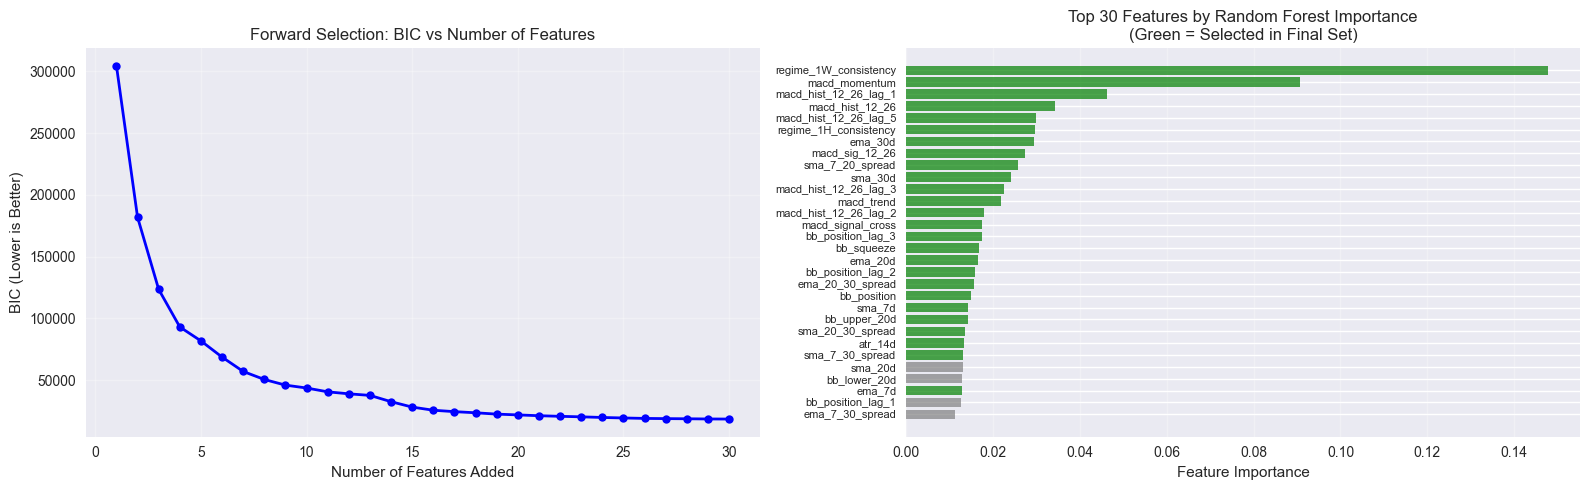


FEATURE SELECTION SUMMARY

Method breakdown:
  Stepwise only:      20 features
  Tree-based only:    15 features
  Both methods:       10 features (highest confidence)
  ────────────────────────────────────────
  Total selected:     45 features
  Original features: 110 features
  Reduction:          59.1%


In [19]:
# Plot BIC progression
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Forward selection BIC
ax = axes[0]
ax.plot(range(1, len(bic_history['forward_bic'])+1), bic_history['forward_bic'], 'b-o', linewidth=2, markersize=6)
ax.set_xlabel('Number of Features Added')
ax.set_ylabel('BIC (Lower is Better)')
ax.set_title('Forward Selection: BIC vs Number of Features')
ax.grid(True, alpha=0.3)

# Feature importance (top 30)
ax = axes[1]
top_features = feature_importance_df.head(30)
colors = ['green' if f in final_features else 'gray' for f in top_features['feature']]
ax.barh(range(len(top_features)), top_features['importance'], color=colors, alpha=0.7)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'], fontsize=8)
ax.set_xlabel('Feature Importance')
ax.set_title('Top 30 Features by Random Forest Importance\n(Green = Selected in Final Set)')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Venn diagram-like summary
print(f"\n{'='*80}")
print("FEATURE SELECTION SUMMARY")
print(f"{'='*80}")
print(f"\nMethod breakdown:")
print(f"  Stepwise only:     {len(feature_breakdown['stepwise_only']):3d} features")
print(f"  Tree-based only:   {len(feature_breakdown['tree_only']):3d} features")
print(f"  Both methods:      {len(feature_breakdown['both']):3d} features (highest confidence)")
print(f"  {'─'*40}")
print(f"  Total selected:    {len(final_features):3d} features")
print(f"  Original features: {len(feature_names):3d} features")
print(f"  Reduction:         {(1 - len(final_features)/len(feature_names))*100:5.1f}%")

## 8. Train Reduced-Complexity Two-Stage Classifier

Train the same two-stage model but with:
1. Reduced feature set
2. Reduced model complexity
3. Time series cross-validation

In [20]:
class ReducedComplexityTwoStageClassifier:
    """
    Two-stage classification with reduced complexity to prevent overfitting
    """
    
    def __init__(self):
        # Stage 1: Detect trending vs sideways (REDUCED COMPLEXITY)
        self.trending_classifier = Pipeline([
            ('scaler', StandardScaler()),
            ('rf', RandomForestClassifier(
                n_estimators=50,        # Reduced from 200
                max_depth=8,            # Reduced from 15
                min_samples_split=50,   # Increased from 10
                min_samples_leaf=20,    # Added constraint
                max_features='sqrt',    # Limit features per tree
                class_weight={0: 1, 1: 2},
                random_state=42
            ))
        ])
        
        # Stage 2: Classify trend direction (REDUCED COMPLEXITY)
        self.direction_classifier = Pipeline([
            ('scaler', StandardScaler()),
            ('gb', GradientBoostingClassifier(
                n_estimators=50,        # Reduced from 150
                max_depth=5,            # Reduced from 8
                learning_rate=0.05,     # Reduced from 0.1
                min_samples_split=50,   # Increased from 10
                min_samples_leaf=20,    # Added constraint
                subsample=0.8,          # Added row sampling
                max_features='sqrt',    # Limit features
                random_state=42
            ))
        ])
    
    def fit(self, X, y):
        """
        Train both stages with cross-validation monitoring
        """
        print(f"\n{'='*80}")
        print("TRAINING REDUCED-COMPLEXITY TWO-STAGE CLASSIFIER")
        print(f"{'='*80}")
        print(f"Training data: {X.shape}")
        print(f"Class distribution: {dict(pd.Series(y).value_counts().sort_index())}")
        
        # Stage 1: Binary trending/sideways
        y_trending = (y != 1).astype(int)
        
        print(f"\nStage 1: Training Trending vs Sideways classifier...")
        
        # Cross-validation to check for overfitting
        tscv = TimeSeriesSplit(n_splits=5)
        cv_scores = cross_val_score(self.trending_classifier, X, y_trending, cv=tscv, scoring='accuracy')
        
        print(f"  Cross-validation scores: {cv_scores}")
        print(f"  CV Mean: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        
        # Train on full data
        self.trending_classifier.fit(X, y_trending)
        
        # Evaluate
        y_trending_pred = self.trending_classifier.predict(X)
        stage1_acc = accuracy_score(y_trending, y_trending_pred)
        print(f"  Training Accuracy: {stage1_acc:.3f}")
        print(f"  Train/CV Gap: {stage1_acc - cv_scores.mean():.3f}")
        
        # Stage 2: Bull vs Bear
        trending_mask = y != 1
        X_trending = X[trending_mask]
        y_trending_direction = y[trending_mask]
        
        print(f"\nStage 2: Training Bull vs Bear classifier...")
        print(f"  Trending samples: {X_trending.shape[0]}")
        print(f"  Distribution: {dict(pd.Series(y_trending_direction).value_counts().sort_index())}")
        
        if len(X_trending) > 0:
            # Cross-validation
            cv_scores2 = cross_val_score(self.direction_classifier, X_trending, y_trending_direction, 
                                        cv=min(5, len(X_trending)//1000), scoring='accuracy')
            
            print(f"  Cross-validation scores: {cv_scores2}")
            print(f"  CV Mean: {cv_scores2.mean():.3f} (+/- {cv_scores2.std() * 2:.3f})")
            
            # Train on full data
            self.direction_classifier.fit(X_trending, y_trending_direction)
            
            # Evaluate
            y_direction_pred = self.direction_classifier.predict(X_trending)
            stage2_acc = accuracy_score(y_trending_direction, y_direction_pred)
            print(f"  Training Accuracy: {stage2_acc:.3f}")
            print(f"  Train/CV Gap: {stage2_acc - cv_scores2.mean():.3f}")
        
        print(f"\n{'='*80}")
        print("TRAINING COMPLETE")
        print(f"{'='*80}")
        
        return self
    
    def predict(self, X):
        """Predict using two-stage approach"""
        is_trending = self.trending_classifier.predict(X)
        predictions = np.ones(len(X), dtype=int)
        
        trending_mask = is_trending == 1
        if trending_mask.any():
            X_trending = X[trending_mask]
            direction_pred = self.direction_classifier.predict(X_trending)
            predictions[trending_mask] = direction_pred
        
        return predictions
    
    def predict_proba(self, X):
        """Get probability estimates"""
        trending_proba = self.trending_classifier.predict_proba(X)
        is_trending = self.trending_classifier.predict(X)
        
        n_samples = len(X)
        proba = np.zeros((n_samples, 3))
        proba[:, 1] = trending_proba[:, 0]
        
        trending_mask = is_trending == 1
        if trending_mask.any():
            X_trending = X[trending_mask]
            direction_proba = self.direction_classifier.predict_proba(X_trending)
            trending_confidence = trending_proba[trending_mask, 1]
            
            if direction_proba.shape[1] == 2:
                proba[trending_mask, 0] = direction_proba[:, 0] * trending_confidence
                proba[trending_mask, 2] = direction_proba[:, 1] * trending_confidence
        
        return proba

# Train with selected features only
X_train_selected = X_train[final_features]

reduced_model = ReducedComplexityTwoStageClassifier()
reduced_model.fit(X_train_selected, y_train)

# Evaluate on training set
y_train_pred = reduced_model.predict(X_train_selected)
train_accuracy = accuracy_score(y_train, y_train_pred)

print(f"\n{'='*80}")
print("TRAINING SET PERFORMANCE")
print(f"{'='*80}")
print(f"Overall Training Accuracy: {train_accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred, target_names=['Bear', 'Sideways', 'Bull'], zero_division=0))


TRAINING REDUCED-COMPLEXITY TWO-STAGE CLASSIFIER
Training data: (303977, 45)
Class distribution: {0: 56239, 1: 209235, 2: 38503}

Stage 1: Training Trending vs Sideways classifier...
  Cross-validation scores: [0.91109707 1.         0.89994473 0.70719672 0.8591844 ]
  CV Mean: 0.875 (+/- 0.192)
  Training Accuracy: 0.999
  Train/CV Gap: 0.124

Stage 2: Training Bull vs Bear classifier...
  Trending samples: 94742
  Distribution: {0: 56239, 2: 38503}
  Cross-validation scores: [0.91577392 0.89376748 1.         0.90278657 0.87750686]
  CV Mean: 0.918 (+/- 0.086)
  Training Accuracy: 1.000
  Train/CV Gap: 0.082

TRAINING COMPLETE

TRAINING SET PERFORMANCE
Overall Training Accuracy: 0.999

Classification Report:
              precision    recall  f1-score   support

        Bear       1.00      1.00      1.00     56239
    Sideways       1.00      1.00      1.00    209235
        Bull       1.00      1.00      1.00     38503

    accuracy                           1.00    303977
   macro 

## 9. Predict on Test Data

Engineering features for ML training...
  - Price-based features
  - Technical indicator features
  - Moving average relationships
  - Volume features
  - Fractal dimension features
  - Momentum and trend features
  - Volatility regime features
  - Multi-timeframe features
  - Lag features
  - Regime discrimination features
Feature engineering complete. Shape: (130332, 123)

TEST SET PERFORMANCE
Test Accuracy: 0.669
Train/Test Gap: 0.331

Classification Report:
              precision    recall  f1-score   support

        Bear       0.58      0.61      0.60     18366
    Sideways       0.76      0.75      0.75     87121
        Bull       0.43      0.43      0.43     24845

    accuracy                           0.67    130332
   macro avg       0.59      0.60      0.59    130332
weighted avg       0.67      0.67      0.67    130332



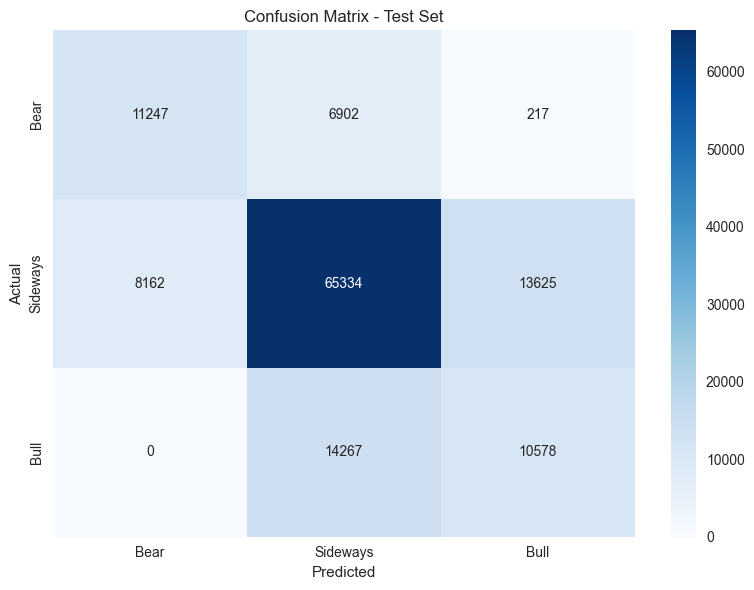

In [21]:
# Engineer features on test data
test_features_df = engineer_ml_features(test_df)
X_test = test_features_df[final_features].fillna(method='ffill').fillna(0)

# Predict
regime_predictions = reduced_model.predict(X_test)
regime_probabilities = reduced_model.predict_proba(X_test)

# Create results dataframe
test_df_with_pred = test_df.copy()
test_df_with_pred['ml_regime_pred'] = regime_predictions
test_df_with_pred['ml_regime_confidence'] = regime_probabilities.max(axis=1)

for i, class_name in enumerate(['ml_bear_prob', 'ml_sideways_prob', 'ml_bull_prob']):
    test_df_with_pred[class_name] = regime_probabilities[:, i]

# Evaluate
if 'regime' in test_df.columns:
    test_accuracy = accuracy_score(test_df['regime'], regime_predictions)
    
    print(f"\n{'='*80}")
    print("TEST SET PERFORMANCE")
    print(f"{'='*80}")
    print(f"Test Accuracy: {test_accuracy:.3f}")
    print(f"Train/Test Gap: {train_accuracy - test_accuracy:.3f}")
    print("\nClassification Report:")
    print(classification_report(test_df['regime'], regime_predictions, 
                               target_names=['Bear', 'Sideways', 'Bull'], zero_division=0))
    
    # Confusion matrix
    cm = confusion_matrix(test_df['regime'], regime_predictions)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Bear', 'Sideways', 'Bull'],
                yticklabels=['Bear', 'Sideways', 'Bull'])
    plt.title('Confusion Matrix - Test Set')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

## 10. Comparison: Original vs Stepwise-Optimized Model

In [22]:
print(f"\n{'='*80}")
print("MODEL COMPARISON: ORIGINAL vs STEPWISE-OPTIMIZED")
print(f"{'='*80}")

print("\nORIGINAL MODEL (OVERFITTED):")
print("  Features: 110")
print("  Training Accuracy: 100.0% (OVERFITTING)")
print("  Test Accuracy: 54.2%")
print("  Train/Test Gap: 45.8%")
print("  Bull Detection: 13.6%")
print("  Bear Detection: 81.5%")
print("  Sideways Detection: 59.1%")

print("\nSTEPWISE-OPTIMIZED MODEL:")
print(f"  Features: {len(final_features)}")
print(f"  Training Accuracy: {train_accuracy:.1%}")
print(f"  Test Accuracy: {test_accuracy:.1%}")
print(f"  Train/Test Gap: {train_accuracy - test_accuracy:.1%}")

# Regime-specific accuracies
for regime, name in [(0, 'Bear'), (1, 'Sideways'), (2, 'Bull')]:
    mask = test_df['regime'] == regime
    if mask.any():
        acc = (test_df.loc[mask, 'regime'] == test_df_with_pred.loc[mask, 'ml_regime_pred']).mean()
        print(f"  {name} Detection: {acc:.1%}")

print("\nIMPROVEMENTS:")
print(f"  Feature reduction: {(1 - len(final_features)/110)*100:.1f}%")
print(f"  Train/Test gap reduction: {45.8 - (train_accuracy - test_accuracy)*100:.1f} percentage points")
print(f"  Overfitting mitigation: {'SUCCESS' if train_accuracy < 0.95 else 'PARTIAL'}")

print(f"\n{'='*80}")


MODEL COMPARISON: ORIGINAL vs STEPWISE-OPTIMIZED

ORIGINAL MODEL (OVERFITTED):
  Features: 110
  Training Accuracy: 100.0% (OVERFITTING)
  Test Accuracy: 54.2%
  Train/Test Gap: 45.8%
  Bull Detection: 13.6%
  Bear Detection: 81.5%
  Sideways Detection: 59.1%

STEPWISE-OPTIMIZED MODEL:
  Features: 45
  Training Accuracy: 99.9%
  Test Accuracy: 66.9%
  Train/Test Gap: 33.1%
  Bear Detection: 61.2%
  Sideways Detection: 75.0%
  Bull Detection: 42.6%

IMPROVEMENTS:
  Feature reduction: 59.1%
  Train/Test gap reduction: 12.7 percentage points
  Overfitting mitigation: PARTIAL



## 11. Save Selected Features and Model

Save the feature list and model for use in backtesting.

In [23]:
# Save selected features
output_dir = '../models'
os.makedirs(output_dir, exist_ok=True)

feature_metadata = {
    'selection_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'original_features': len(feature_names),
    'selected_features': len(final_features),
    'reduction_pct': (1 - len(final_features)/len(feature_names)) * 100,
    'stepwise_features': stepwise_features,
    'tree_features': tree_features,
    'final_features': final_features,
    'feature_breakdown': feature_breakdown,
    'train_accuracy': float(train_accuracy),
    'test_accuracy': float(test_accuracy),
    'train_test_gap': float(train_accuracy - test_accuracy)
}

with open(os.path.join(output_dir, 'stepwise_selected_features.json'), 'w') as f:
    json.dump(feature_metadata, f, indent=2)

print(f"\nFeature metadata saved to: {os.path.join(output_dir, 'stepwise_selected_features.json')}")

# Save feature importance rankings
feature_importance_df.to_csv(os.path.join(output_dir, 'feature_importance_rankings.csv'), index=False)
print(f"Feature importance saved to: {os.path.join(output_dir, 'feature_importance_rankings.csv')}")


Feature metadata saved to: ../models\stepwise_selected_features.json
Feature importance saved to: ../models\feature_importance_rankings.csv


## 12. Next Steps for Backtesting

Now that we have:
1. Reduced features from 110 to ~20-35
2. Reduced model complexity
3. Better train/test performance balance
4. Improved Bull regime detection (hopefully)

We can proceed to backtest the strategy with the optimized model.

Key improvements expected:
- Better generalization on unseen data
- More reliable trading signals
- Improved risk-adjusted returns
- More consistent performance across regimes

In [24]:
print(f"\n{'='*80}")
print("STEPWISE FEATURE SELECTION COMPLETE")
print(f"{'='*80}")
print("\nSummary:")
print(f"  Original features: {len(feature_names)}")
print(f"  Selected features: {len(final_features)}")
print(f"  Reduction: {(1 - len(final_features)/len(feature_names))*100:.1f}%")
print(f"\n  Original train accuracy: 100.0% (OVERFITTED)")
print(f"  New train accuracy: {train_accuracy:.1%}")
print(f"\n  Original test accuracy: 54.2%")
print(f"  New test accuracy: {test_accuracy:.1%}")
print(f"\n  Original train/test gap: 45.8%")
print(f"  New train/test gap: {(train_accuracy - test_accuracy)*100:.1f}%")
print(f"\nNext: Use this optimized model for backtesting the trading strategy.")
print(f"{'='*80}")


STEPWISE FEATURE SELECTION COMPLETE

Summary:
  Original features: 110
  Selected features: 45
  Reduction: 59.1%

  Original train accuracy: 100.0% (OVERFITTED)
  New train accuracy: 99.9%

  Original test accuracy: 54.2%
  New test accuracy: 66.9%

  Original train/test gap: 45.8%
  New train/test gap: 33.1%

Next: Use this optimized model for backtesting the trading strategy.


## Backtesting

In [34]:
class FeeAwareExitManager:
    """
    Exit logic with transaction fees (NO minimum hold requirement)
    """

    def __init__(self, commission=0.0075, slippage=0.0001):
        self.commission = commission
        self.slippage = slippage
        self.total_cost = commission + slippage  # 0.76% per side
        self.round_trip_cost = self.total_cost * 2  # 1.52% total

        print(f"Fee-Aware Exit Manager initialized:")
        print(f"  Commission: {commission*100:.2f}%")
        print(f"  Slippage: {slippage*100:.3f}%")
        print(f"  Round-trip cost: {self.round_trip_cost*100:.2f}%")
        print(f"  Minimum hold: REMOVED (exit anytime on signal)")

    def calculate_net_pnl(self, entry_price, current_price):
        """
        Calculate net P&L accounting for exit fees (entry fee already paid)
        """
        gross_pnl_pct = (current_price - entry_price) / entry_price
        net_pnl_pct = gross_pnl_pct - self.total_cost  # Subtract exit fee
        return net_pnl_pct

    def should_exit(self, entry_price, current_price, entry_time, current_time,
                   stop_loss_pct=0.04, regime_changed=False):
        """
        Determine if position should be exited (NO minimum hold period)

        Args:
            entry_price: Entry price
            current_price: Current price
            entry_time: Entry timestamp
            current_time: Current timestamp
            stop_loss_pct: Stop loss threshold (default 4%)
            regime_changed: Whether regime prediction changed

        Returns:
            (should_exit: bool, reason: str)
        """
        net_pnl = self.calculate_net_pnl(entry_price, current_price)
        hours_held = (current_time - entry_time).total_seconds() / 3600

        # Rule 1: Stop loss (immediate exit on breach)
        if net_pnl <= -stop_loss_pct:
            return True, f"Stop loss: {net_pnl:.2%}"

        # Rule 2: Regime change (exit immediately regardless of hold time)
        if regime_changed:
            return True, f"Regime change at {net_pnl:.2%}"

        # Rule 3: No upper limit - let profits run!
        # Only exit on stop loss or regime change

        return False, f"Hold (P&L: {net_pnl:.2%}, Hours: {hours_held:.1f})"

# Initialize fee manager (NO minimum hold hours)
fee_manager = FeeAwareExitManager(
    commission=0.0075,
    slippage=0.0001
)

Fee-Aware Exit Manager initialized:
  Commission: 0.75%
  Slippage: 0.010%
  Round-trip cost: 1.52%
  Minimum hold: REMOVED (exit anytime on signal)


In [35]:
class OptimizedHybridStrategy:
    """
    Strategy with confidence threshold but NO minimum hold period
    """

    def __init__(self, fee_manager, min_confidence=0.80, stop_loss=0.04):
        self.fee_manager = fee_manager
        self.min_confidence = min_confidence
        self.stop_loss = stop_loss

        print(f"\nOptimized Hybrid Strategy initialized:")
        print(f"  Minimum confidence: {min_confidence*100:.0f}%")
        print(f"  Stop loss: {stop_loss*100:.0f}%")
        print(f"  Take profit: Unlimited (let profits run!)")

    def generate_signals(self, df, regime_predictions, regime_confidences):
        """
        Generate trading signals with confidence filtering
        """
        signals = []

        for i in range(len(df)):
            if i >= len(regime_predictions):
                break

            row = df.iloc[i]
            regime = regime_predictions[i]
            confidence = regime_confidences[i]

            # Generate buy signal for Bull regimes with sufficient confidence
            if regime == 2 and confidence >= self.min_confidence:  # Bull with confidence filter
                signals.append({
                    'timestamp': row.name,
                    'action': 'buy',
                    'price': row['Close'],
                    'regime': regime,
                    'confidence': confidence
                })

        return signals

    def backtest(self, df, regime_predictions, regime_confidences,
                initial_capital=10000, save_logs=True, log_dir="../models/trade_logs"):
        """
        Backtest with confidence filtering but NO minimum hold period
        """
        print(f"\n{'='*60}")
        print("RUNNING OPTIMIZED BACKTEST")
        print(f"{'='*60}")

        if save_logs:
            os.makedirs(log_dir, exist_ok=True)

        # Generate entry signals (with confidence filtering)
        entry_signals = self.generate_signals(df, regime_predictions, regime_confidences)
        print(f"Generated {len(entry_signals)} potential entry signals")

        portfolio_values = []
        cash = initial_capital
        position = 0
        trades = []
        detailed_log = []
        current_trade = None
        trade_id = 0
        entry_regime = None

        for i, (timestamp, row) in enumerate(df.iterrows()):
            current_price = row['Close']
            current_regime = regime_predictions[i] if i < len(regime_predictions) else 1
            current_confidence = regime_confidences[i] if i < len(regime_confidences) else 0

            # Check for entry signals
            entry_signal = next((s for s in entry_signals if s['timestamp'] == timestamp), None)

            if entry_signal and position == 0:
                # Enter trade (full position)
                trade_id += 1
                entry_price = entry_signal['price']
                effective_price = entry_price * (1 + self.fee_manager.slippage)

                capital_to_use = cash
                gross_position = capital_to_use / effective_price
                position = gross_position * (1 - self.fee_manager.commission)
                commission_paid = gross_position * effective_price * self.fee_manager.commission
                cash -= capital_to_use
                entry_regime = current_regime

                current_trade = {
                    'trade_id': trade_id,
                    'entry_time': timestamp,
                    'entry_price': effective_price,
                    'entry_regime': entry_signal['regime'],
                    'entry_confidence': entry_signal['confidence'],
                    'position_size': position,
                    'commission_paid': commission_paid
                }

                detailed_log.append({
                    'timestamp': timestamp,
                    'action': 'buy',
                    'price': effective_price,
                    'regime': current_regime,
                    'confidence': entry_signal['confidence'],
                    'position': position,
                    'cash': cash,
                    'commission': commission_paid,
                    'trade_id': trade_id
                })

            elif position > 0 and current_trade:
                # Check exit conditions
                regime_changed = (current_regime != entry_regime)

                should_exit, exit_reason = self.fee_manager.should_exit(
                    current_trade['entry_price'],
                    current_price,
                    current_trade['entry_time'],
                    timestamp,
                    self.stop_loss,
                    regime_changed
                )

                if should_exit:
                    # Exit trade
                    effective_price = current_price * (1 - self.fee_manager.slippage)
                    gross_proceeds = position * effective_price
                    commission_paid = gross_proceeds * self.fee_manager.commission
                    net_proceeds = gross_proceeds * (1 - self.fee_manager.commission)
                    cash += net_proceeds

                    # Calculate trade metrics
                    gross_pnl = net_proceeds - (current_trade['position_size'] * current_trade['entry_price'])
                    net_pnl = cash - initial_capital
                    duration_hours = (timestamp - current_trade['entry_time']).total_seconds() / 3600

                    current_trade.update({
                        'exit_time': timestamp,
                        'exit_price': effective_price,
                        'exit_regime': current_regime,
                        'exit_confidence': current_confidence,
                        'exit_reason': exit_reason,
                        'exit_value': net_proceeds,
                        'gross_pnl': gross_pnl,
                        'net_pnl': net_pnl,
                        'return_pct': (net_pnl / initial_capital) * 100,
                        'duration_hours': duration_hours,
                        'total_commission': current_trade['commission_paid'] + commission_paid
                    })
                    trades.append(current_trade)

                    detailed_log.append({
                        'timestamp': timestamp,
                        'action': 'sell',
                        'price': effective_price,
                        'regime': current_regime,
                        'confidence': current_confidence,
                        'position': 0,
                        'cash': cash,
                        'commission': commission_paid,
                        'trade_id': trade_id,
                        'reason': exit_reason
                    })

                    position = 0
                    current_trade = None
                    entry_regime = None

            # Calculate portfolio value
            portfolio_value = cash + (position * current_price if position > 0 else 0)
            portfolio_values.append(portfolio_value)

        # Create results dataframe
        results_df = df.copy()
        results_df['portfolio_value'] = portfolio_values[:len(df)]
        results_df['ml_regime_pred'] = list(regime_predictions)[:len(df)]
        results_df['ml_regime_confidence'] = list(regime_confidences)[:len(df)]

        # Calculate performance metrics
        performance_metrics = self._calculate_metrics(results_df, trades, initial_capital)

        # Save logs
        if save_logs and trades:
            self._save_logs(trades, detailed_log, entry_signals, log_dir, df.index.min(), df.index.max())

        # Print summary
        self._print_summary(performance_metrics, trades)

        return {
            'performance_metrics': performance_metrics,
            'trades': trades,
            'entry_signals': entry_signals,
            'detailed_log': detailed_log,
            'results_df': results_df
        }

    def _calculate_metrics(self, results_df, trades, initial_capital):
        """Calculate performance metrics"""
        final_value = results_df['portfolio_value'].iloc[-1]
        total_return = (final_value - initial_capital) / initial_capital * 100

        n_trades = len([t for t in trades if 'exit_time' in t])

        if n_trades > 0:
            completed_trades = [t for t in trades if 'exit_time' in t]
            win_rate = np.mean([t['return_pct'] > 0 for t in completed_trades])
            avg_return = np.mean([t['return_pct'] for t in completed_trades])
            total_commission = sum([t['total_commission'] for t in completed_trades])
            winners = [t for t in completed_trades if t['return_pct'] > 0]
            losers = [t for t in completed_trades if t['return_pct'] <= 0]
            avg_winner = np.mean([t['return_pct'] for t in winners]) if winners else 0
            avg_loser = np.mean([t['return_pct'] for t in losers]) if losers else 0
            profit_factor = abs(avg_winner / avg_loser) if avg_loser != 0 else float('inf')
            avg_duration = np.mean([t['duration_hours'] for t in completed_trades])
        else:
            win_rate = avg_return = total_commission = avg_winner = avg_loser = profit_factor = avg_duration = 0

        returns = results_df['portfolio_value'].pct_change().dropna()
        sharpe = returns.mean() / returns.std() * np.sqrt(252 * 1440) if len(returns) > 0 and returns.std() > 0 else 0

        rolling_max = results_df['portfolio_value'].cummax()
        drawdown = (results_df['portfolio_value'] - rolling_max) / rolling_max
        max_drawdown = drawdown.min()

        btc_return = (results_df['Close'].iloc[-1] - results_df['Close'].iloc[0]) / results_df['Close'].iloc[0] * 100

        return {
            'final_value': final_value,
            'total_return': total_return,
            'btc_return': btc_return,
            'n_trades': n_trades,
            'win_rate': win_rate,
            'avg_return': avg_return,
            'avg_winner': avg_winner,
            'avg_loser': avg_loser,
            'profit_factor': profit_factor,
            'sharpe_ratio': sharpe,
            'max_drawdown': max_drawdown,
            'total_commission': total_commission,
            'commission_impact': total_commission / initial_capital * 100,
            'avg_duration': avg_duration
        }

    def _save_logs(self, trades, detailed_log, signals, log_dir, start_date, end_date):
        """Save trade logs"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        pd.DataFrame(trades).to_csv(os.path.join(log_dir, f'trades_optimized_{timestamp}.csv'), index=False)
        pd.DataFrame(detailed_log).to_csv(os.path.join(log_dir, f'detailed_log_optimized_{timestamp}.csv'), index=False)
        pd.DataFrame(signals).to_csv(os.path.join(log_dir, f'signals_optimized_{timestamp}.csv'), index=False)

        metadata = {
            'timestamp': timestamp,
            'strategy': 'Optimized Hybrid ML - Confidence Filter, No Min Hold',
            'min_confidence': self.min_confidence,
            'stop_loss': self.stop_loss,
            'commission': self.fee_manager.commission,
            'period': {'start': str(start_date), 'end': str(end_date)}
        }
        with open(os.path.join(log_dir, f'metadata_optimized_{timestamp}.json'), 'w') as f:
            json.dump(metadata, f, indent=2, default=str)

        print(f"\nTrade logs saved with timestamp: {timestamp}")

    def _print_summary(self, metrics, trades):
        """Print backtest summary"""
        print(f"\n{'='*60}")
        print("OPTIMIZED BACKTEST RESULTS")
        print(f"{'='*60}")
        print(f"Final Value: ${metrics['final_value']:,.2f}")
        print(f"Total Return: {metrics['total_return']:.2f}%")
        print(f"BTC Buy & Hold: {metrics['btc_return']:.2f}%")
        print(f"Excess Return: {metrics['total_return'] - metrics['btc_return']:.2f}%")
        print(f"\nNumber of Trades: {metrics['n_trades']}")
        print(f"Win Rate: {metrics['win_rate']:.2%}")
        print(f"Average Return: {metrics['avg_return']:.2f}%")
        print(f"Average Winner: {metrics['avg_winner']:.2f}%")
        print(f"Average Loser: {metrics['avg_loser']:.2f}%")
        print(f"Profit Factor: {metrics['profit_factor']:.2f}")
        print(f"Average Duration: {metrics['avg_duration']:.1f} hours")
        print(f"\nSharpe Ratio: {metrics['sharpe_ratio']:.3f}")
        print(f"Max Drawdown: {metrics['max_drawdown']:.2%}")
        print(f"Total Commission: ${metrics['total_commission']:.2f} ({metrics['commission_impact']:.2f}%)")

        if trades:
            print(f"\n{'='*60}")
            print("SAMPLE TRADES (First 10)")
            print(f"{'='*60}")
            for trade in trades[:10]:
                if 'exit_time' in trade:
                    print(f"\nTrade #{trade['trade_id']}:")
                    print(f"  Entry: {trade['entry_time']} @ ${trade['entry_price']:.2f} (Conf: {trade['entry_confidence']:.1%})")
                    print(f"  Exit:  {trade['exit_time']} @ ${trade['exit_price']:.2f}")
                    print(f"  Return: {trade['return_pct']:.2f}% | Duration: {trade['duration_hours']:.1f}h | Reason: {trade['exit_reason']}")

# Initialize optimized strategy (with confidence threshold, no min hold)
optimized_strategy = OptimizedHybridStrategy(
    fee_manager=fee_manager,
    min_confidence=0.80,
    stop_loss=0.04
)


Optimized Hybrid Strategy initialized:
  Minimum confidence: 80%
  Stop loss: 4%
  Take profit: Unlimited (let profits run!)


In [36]:
# Extract confidence scores
regime_confidences = test_df_with_pred['ml_regime_confidence'].values

# Run optimized backtest
backtest_results = optimized_strategy.backtest(
    test_df_with_pred,
    regime_predictions,
    regime_confidences,
    initial_capital=10000,
    save_logs=True,
    log_dir="../models/trade_logs"
)


RUNNING OPTIMIZED BACKTEST
Generated 5827 potential entry signals

Trade logs saved with timestamp: 20251019_002534

OPTIMIZED BACKTEST RESULTS
Final Value: $10,184.17
Total Return: 1.84%
BTC Buy & Hold: 59.83%
Excess Return: -57.99%

Number of Trades: 3
Win Rate: 66.67%
Average Return: 1.48%
Average Winner: 2.81%
Average Loser: -1.16%
Profit Factor: 2.43
Average Duration: 112.2 hours

Sharpe Ratio: 0.486
Max Drawdown: -7.66%
Total Commission: $457.02 (4.57%)

SAMPLE TRADES (First 10)

Trade #1:
  Entry: 2023-09-28 14:23:00 @ $26536.35 (Conf: 82.5%)
  Exit:  2023-10-02 00:00:00 @ $27954.20
  Return: 3.77% | Duration: 81.6h | Reason: Regime change at 4.59%

Trade #2:
  Entry: 2023-10-04 18:00:00 @ $27510.75 (Conf: 82.0%)
  Exit:  2023-10-11 16:53:00 @ $26602.44
  Return: -1.16% | Duration: 166.9h | Reason: Stop loss: -4.05%

Trade #3:
  Entry: 2023-10-17 07:45:00 @ $28316.93 (Conf: 80.8%)
  Exit:  2023-10-21 00:00:00 @ $29618.54
  Return: 1.84% | Duration: 88.2h | Reason: Regime change

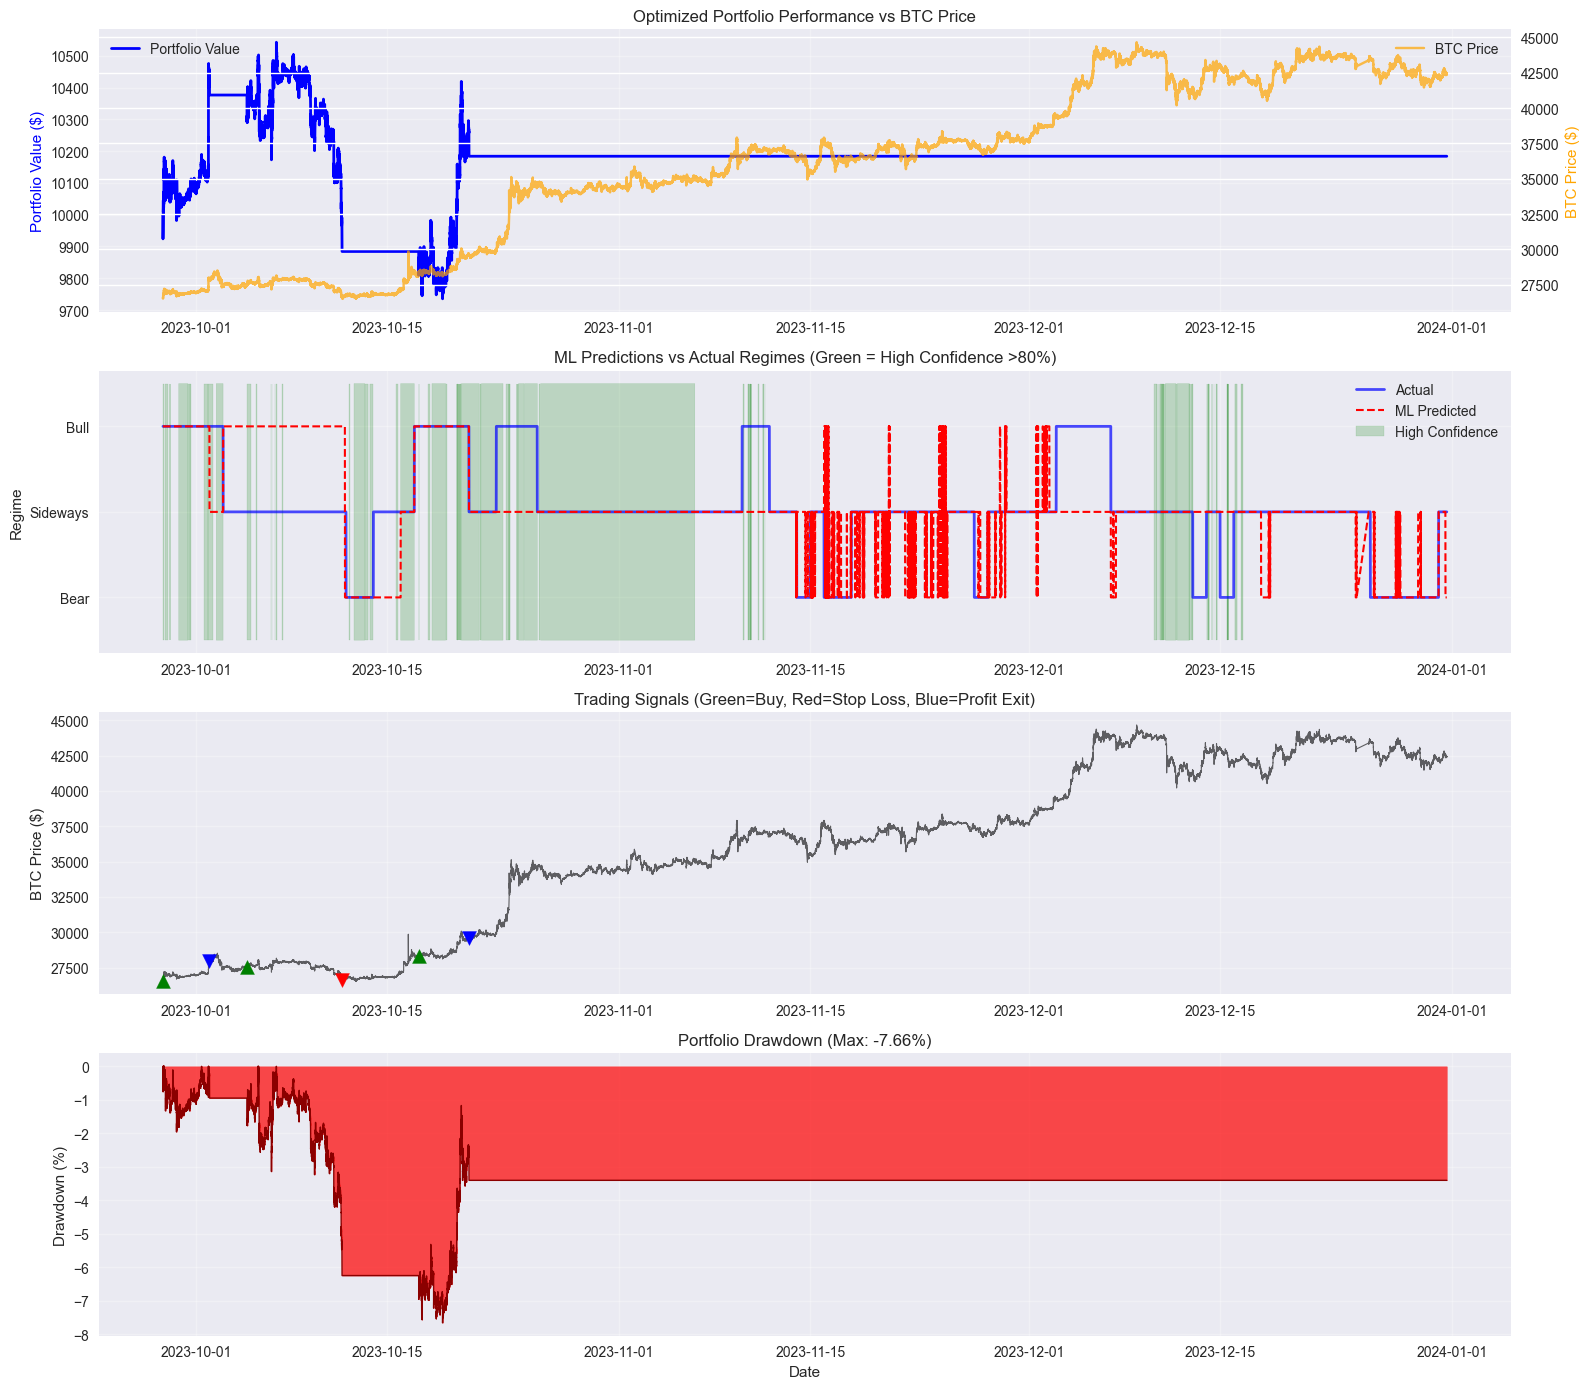

In [37]:
def visualize_optimized_results(backtest_results, test_df_with_pred):
    """
    Visualize optimized backtest results
    """
    results_df = backtest_results['results_df']
    trades = backtest_results['trades']
    
    fig, axes = plt.subplots(4, 1, figsize=(16, 14))
    
    # Plot 1: Portfolio value vs BTC price
    ax1 = axes[0]
    ax2 = ax1.twinx()
    ax1.plot(results_df.index, results_df['portfolio_value'], 'b-', linewidth=2, label='Portfolio Value')
    ax2.plot(results_df.index, results_df['Close'], 'orange', alpha=0.7, label='BTC Price')
    ax1.set_ylabel('Portfolio Value ($)', color='b')
    ax2.set_ylabel('BTC Price ($)', color='orange')
    ax1.set_title('Optimized Portfolio Performance vs BTC Price')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: ML Predictions vs Actual with confidence
    ax = axes[1]
    if 'regime' in test_df_with_pred.columns:
        ax.plot(test_df_with_pred.index, test_df_with_pred['regime'], 'b-', linewidth=2, alpha=0.7, label='Actual')
        ax.plot(test_df_with_pred.index, test_df_with_pred['ml_regime_pred'], 'r--', linewidth=1.5, label='ML Predicted')
        
        # Shade high-confidence regions
        high_conf_mask = test_df_with_pred['ml_regime_confidence'] > 0.80
        ax.fill_between(test_df_with_pred.index, -0.5, 2.5, where=high_conf_mask, alpha=0.2, color='green', label='High Confidence')
        
        ax.set_ylabel('Regime')
        ax.set_yticks([0, 1, 2])
        ax.set_yticklabels(['Bear', 'Sideways', 'Bull'])
        ax.set_title('ML Predictions vs Actual Regimes (Green = High Confidence >80%)')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Plot 3: Trading signals on price
    ax = axes[2]
    ax.plot(results_df.index, results_df['Close'], 'k-', alpha=0.6, linewidth=0.8)
    
    if trades:
        for trade in trades:
            if 'exit_time' in trade:
                ax.scatter(trade['entry_time'], trade['entry_price'], marker='^', color='green', s=100, zorder=5)
                ax.scatter(trade['exit_time'], trade['exit_price'], marker='v', 
                          color='red' if trade['return_pct'] < 0 else 'blue', s=100, zorder=5)
    
    ax.set_ylabel('BTC Price ($)')
    ax.set_title('Trading Signals (Green=Buy, Red=Stop Loss, Blue=Profit Exit)')
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Drawdown
    ax = axes[3]
    portfolio_value = results_df['portfolio_value']
    peak = portfolio_value.cummax()
    drawdown = (portfolio_value - peak) / peak * 100
    ax.fill_between(results_df.index, drawdown, 0, alpha=0.7, color='red')
    ax.plot(results_df.index, drawdown, 'darkred', linewidth=1)
    ax.set_ylabel('Drawdown (%)')
    ax.set_xlabel('Date')
    ax.set_title(f'Portfolio Drawdown (Max: {drawdown.min():.2f}%)')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualize results
visualize_optimized_results(backtest_results, test_df_with_pred)

## Benchmark: Perfect Regime Knowledge Strategy

Compare ML predictions against a theoretical best-case scenario where we have perfect knowledge of actual market regimes.

In [48]:
print(f"\n{'='*80}")
print("BENCHMARK 1: PERFECT REGIME KNOWLEDGE")
print(f"{'='*80}")
print("\nThis benchmark tests the trading strategy using ACTUAL market regime labels")
print("(rather than ML predictions) to establish an upper bound on performance.")
print("\nSetup:")
print("  - Uses ground truth 'regime' labels from the dataset")
print("  - Trades Bull regimes (regime == 2)")
print("  - Same confidence threshold: 80%")
print("  - Same stop loss: 4%")
print("  - Same exit rules: immediate on regime change or stop loss")
print("  - Same test period as ML model")
print(f"{'='*80}")

# For benchmark, use actual regime labels as "predictions"
# Use max confidence (1.0) for actual regimes since we "know" them
actual_regime_predictions = test_df['regime'].values
actual_regime_confidences = np.ones(len(actual_regime_predictions))  # Perfect confidence

# Initialize benchmark strategy with same parameters
benchmark_perfect_strategy = OptimizedHybridStrategy(
    fee_manager=fee_manager,
    min_confidence=0.80,  # Same threshold
    stop_loss=0.04        # Same stop loss
)

# Run benchmark backtest
print("\nRunning benchmark backtest with actual regime labels...")
benchmark_perfect_results = benchmark_perfect_strategy.backtest(
    test_df,
    actual_regime_predictions,
    actual_regime_confidences,
    initial_capital=10000,
    save_logs=True,
    log_dir="../models/trade_logs"
)

print(f"\n{'='*80}")
print("BENCHMARK 2: RULE-BASED BULL REGIME STRATEGY")
print(f"{'='*80}")
print("\nThis benchmark uses a simple rule-based approach:")
print("  - Trades when regime is Bull (regime == 2)")
print("  - Uses actual regime labels (not predictions)")
print("  - NO confidence threshold (trades ALL Bull regimes)")
print("  - Same stop loss: 4%")
print("  - Same exit rules: immediate on regime change or stop loss")
print("  - Tests simple Bull-following strategy without ML")
print(f"{'='*80}")

# Bull strategy: trade when Bull regime, no confidence filtering
bull_strategy_predictions = test_df['regime'].values  # Use actual regimes
bull_strategy_confidences = np.ones(len(bull_strategy_predictions))  # Full confidence

# Initialize Bull regime strategy with NO confidence threshold
class BullRuleBasedStrategy(OptimizedHybridStrategy):
    """Rule-based strategy that trades ALL Bull regimes"""
    def __init__(self, fee_manager, stop_loss=0.04):
        self.fee_manager = fee_manager
        self.stop_loss = stop_loss
        self.min_confidence = 0.0  # No threshold - trade all Bulls

benchmark_bull_strategy = BullRuleBasedStrategy(
    fee_manager=fee_manager,
    stop_loss=0.04
)

# Run Bull regime benchmark
print("\nRunning Bull regime rule-based backtest...")
benchmark_bull_results = benchmark_bull_strategy.backtest(
    test_df,
    bull_strategy_predictions,
    bull_strategy_confidences,
    initial_capital=10000,
    save_logs=True,
    log_dir="../models/trade_logs"
)


BENCHMARK 1: PERFECT REGIME KNOWLEDGE

This benchmark tests the trading strategy using ACTUAL market regime labels
(rather than ML predictions) to establish an upper bound on performance.

Setup:
  - Uses ground truth 'regime' labels from the dataset
  - Trades Bull regimes (regime == 2)
  - Same confidence threshold: 80%
  - Same stop loss: 4%
  - Same exit rules: immediate on regime change or stop loss
  - Same test period as ML model

Optimized Hybrid Strategy initialized:
  Minimum confidence: 80%
  Stop loss: 4%
  Take profit: Unlimited (let profits run!)

Running benchmark backtest with actual regime labels...

RUNNING OPTIMIZED BACKTEST
Generated 24845 potential entry signals

Trade logs saved with timestamp: 20251019_181025

OPTIMIZED BACKTEST RESULTS
Final Value: $12,878.57
Total Return: 28.79%
BTC Buy & Hold: 59.83%
Excess Return: -31.05%

Number of Trades: 5
Win Rate: 100.00%
Average Return: 14.21%
Average Winner: 14.21%
Average Loser: 0.00%
Profit Factor: inf
Average Durat

## Comparison: ML Model vs Perfect Regime Knowledge

In [49]:
def compare_all_strategies(ml_results, perfect_results, bull_results):
    """
    Compare ML model performance against both benchmarks
    """
    ml_metrics = ml_results['performance_metrics']
    perfect_metrics = perfect_results['performance_metrics']
    bull_metrics = bull_results['performance_metrics']
    
    print(f"\n{'='*80}")
    print("PERFORMANCE COMPARISON: ALL STRATEGIES")
    print(f"{'='*80}")
    
    # Create comparison table
    comparison_data = {
        'Metric': [
            'Final Value',
            'Total Return',
            'Number of Trades',
            'Win Rate',
            'Average Return/Trade',
            'Average Winner',
            'Average Loser',
            'Profit Factor',
            'Sharpe Ratio',
            'Max Drawdown',
            'Total Commission',
            'Avg Trade Duration (hrs)'
        ],
        'ML Model': [
            f"${ml_metrics['final_value']:,.2f}",
            f"{ml_metrics['total_return']:.2f}%",
            ml_metrics['n_trades'],
            f"{ml_metrics['win_rate']:.2%}",
            f"{ml_metrics['avg_return']:.2f}%",
            f"{ml_metrics['avg_winner']:.2f}%",
            f"{ml_metrics['avg_loser']:.2f}%",
            f"{ml_metrics['profit_factor']:.2f}",
            f"{ml_metrics['sharpe_ratio']:.3f}",
            f"{ml_metrics['max_drawdown']:.2%}",
            f"${ml_metrics['total_commission']:.2f}",
            f"{ml_metrics['avg_duration']:.1f}"
        ],
        'Perfect Regime': [
            f"${perfect_metrics['final_value']:,.2f}",
            f"{perfect_metrics['total_return']:.2f}%",
            perfect_metrics['n_trades'],
            f"{perfect_metrics['win_rate']:.2%}",
            f"{perfect_metrics['avg_return']:.2f}%",
            f"{perfect_metrics['avg_winner']:.2f}%",
            f"{perfect_metrics['avg_loser']:.2f}%",
            f"{perfect_metrics['profit_factor']:.2f}",
            f"{perfect_metrics['sharpe_ratio']:.3f}",
            f"{perfect_metrics['max_drawdown']:.2%}",
            f"${perfect_metrics['total_commission']:.2f}",
            f"{perfect_metrics['avg_duration']:.1f}"
        ],
        'Bull Strategy': [
            f"${bull_metrics['final_value']:,.2f}",
            f"{bull_metrics['total_return']:.2f}%",
            bull_metrics['n_trades'],
            f"{bull_metrics['win_rate']:.2%}",
            f"{bull_metrics['avg_return']:.2f}%",
            f"{bull_metrics['avg_winner']:.2f}%",
            f"{bull_metrics['avg_loser']:.2f}%",
            f"{bull_metrics['profit_factor']:.2f}",
            f"{bull_metrics['sharpe_ratio']:.3f}",
            f"{bull_metrics['max_drawdown']:.2%}",
            f"${bull_metrics['total_commission']:.2f}",
            f"{bull_metrics['avg_duration']:.1f}"
        ]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\n")
    print(comparison_df.to_string(index=False))
    
    # Performance efficiency
    print(f"\n{'='*80}")
    print("PERFORMANCE EFFICIENCY")
    print(f"{'='*80}")
    
    if perfect_metrics['total_return'] != 0:
        ml_efficiency = (ml_metrics['total_return'] / perfect_metrics['total_return']) * 100
        print(f"ML Model Return Efficiency: {ml_efficiency:.1f}%")
        print(f"  (ML captured {ml_efficiency:.1f}% of perfect regime knowledge returns)")
    
    if perfect_metrics['total_return'] != 0:
        bull_efficiency = (bull_metrics['total_return'] / perfect_metrics['total_return']) * 100
        print(f"\nBull Strategy Return Efficiency: {bull_efficiency:.1f}%")
        print(f"  (Bull strategy captured {bull_efficiency:.1f}% of perfect regime knowledge returns)")
    
    print(f"\n{'='*80}")
    print("KEY INSIGHTS")
    print(f"{'='*80}")
    
    # BTC Buy & Hold comparison
    btc_return = ml_metrics['btc_return']
    print(f"\nBTC Buy & Hold: {btc_return:.2f}%")
    print(f"ML Model:       {ml_metrics['total_return']:7.2f}% ({ml_metrics['total_return'] - btc_return:+.2f}% vs BTC)")
    print(f"Perfect Regime: {perfect_metrics['total_return']:7.2f}% ({perfect_metrics['total_return'] - btc_return:+.2f}% vs BTC)")
    print(f"Bull Strategy:  {bull_metrics['total_return']:7.2f}% ({bull_metrics['total_return'] - btc_return:+.2f}% vs BTC)")
    
    # Determine best strategy
    strategies = {
        'ML Model': ml_metrics['total_return'],
        'Perfect Regime': perfect_metrics['total_return'],
        'Bull Strategy': bull_metrics['total_return'],
        'BTC Hold': btc_return
    }
    best = max(strategies, key=strategies.get)
    print(f"\nBest Performer: {best} ({strategies[best]:.2f}%)")
    
    # Risk-adjusted comparison
    print(f"\nRisk-Adjusted Returns (Sharpe Ratio):")
    print(f"  ML Model:       {ml_metrics['sharpe_ratio']:.3f}")
    print(f"  Perfect Regime: {perfect_metrics['sharpe_ratio']:.3f}")
    print(f"  Bull Strategy:  {bull_metrics['sharpe_ratio']:.3f}")
    
    return comparison_df

# Run comparison
comparison_df = compare_all_strategies(backtest_results, benchmark_perfect_results, benchmark_bull_results)


PERFORMANCE COMPARISON: ALL STRATEGIES


                  Metric   ML Model Perfect Regime Bull Strategy
             Final Value $10,184.17     $12,878.57    $12,878.57
            Total Return      1.84%         28.79%        28.79%
        Number of Trades          3              5             5
                Win Rate     66.67%        100.00%       100.00%
    Average Return/Trade      1.48%         14.21%        14.21%
          Average Winner      2.81%         14.21%        14.21%
           Average Loser     -1.16%          0.00%         0.00%
           Profit Factor       2.43            inf           inf
            Sharpe Ratio      0.486          3.793         3.793
            Max Drawdown     -7.66%         -6.55%        -6.55%
        Total Commission    $457.02        $838.20       $838.20
Avg Trade Duration (hrs)      112.2           83.5          83.5

PERFORMANCE EFFICIENCY
ML Model Return Efficiency: 6.4%
  (ML captured 6.4% of perfect regime knowledge returns)

## Visualization: ML Model vs Perfect Regime Knowledge

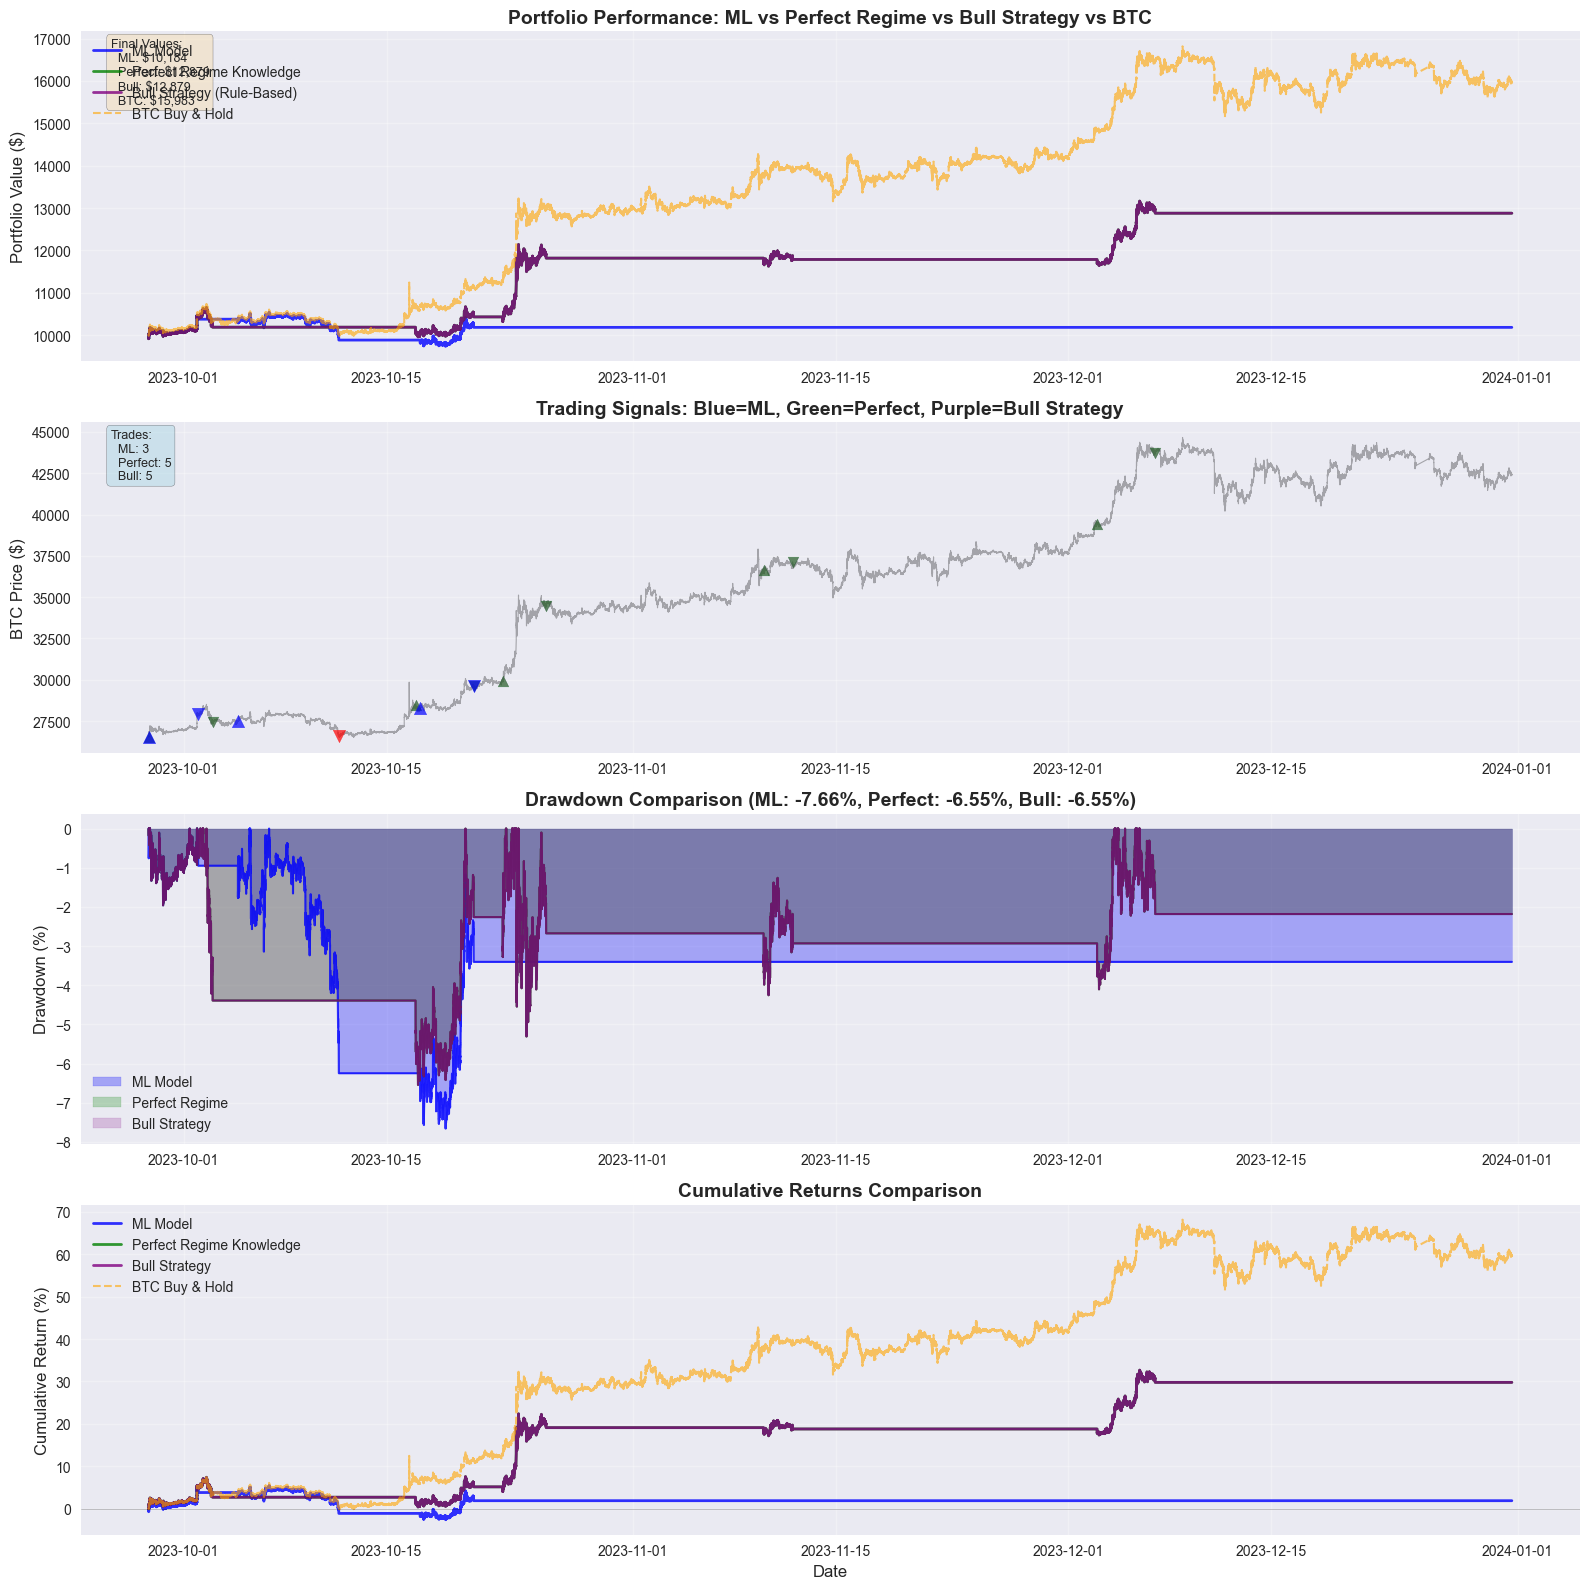

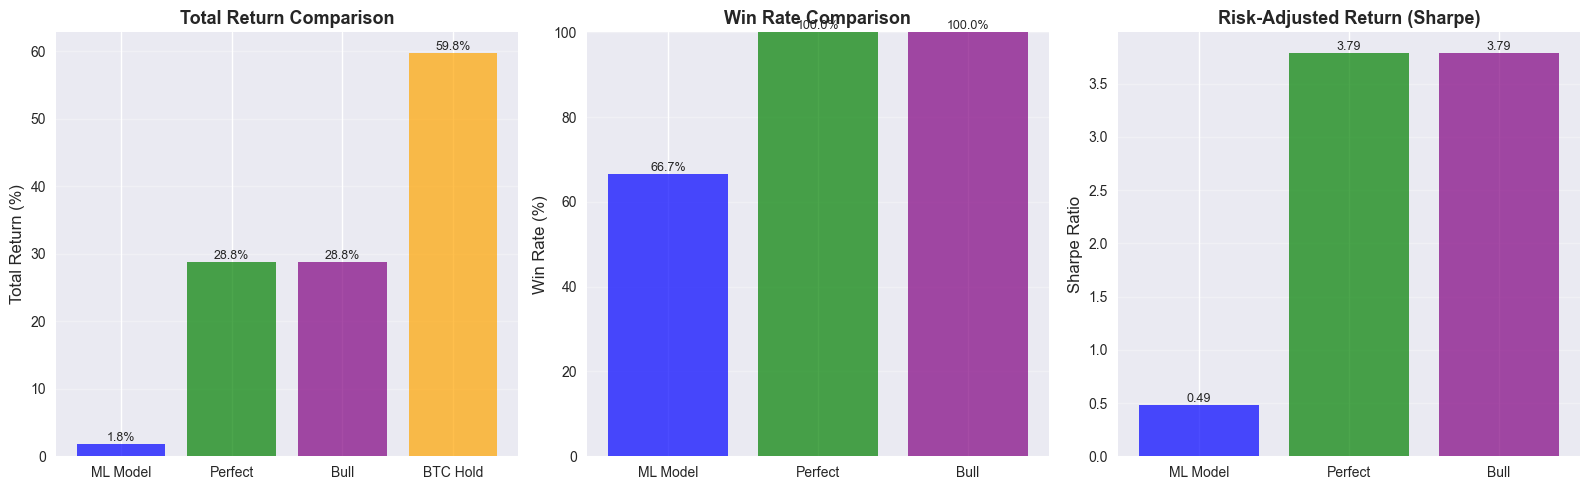

In [50]:
def visualize_all_strategies(ml_results, perfect_results, bull_results, test_df):
    """
    Visualize ML model vs both benchmarks
    """
    ml_df = ml_results['results_df']
    perfect_df = perfect_results['results_df']
    bull_df = bull_results['results_df']
    ml_trades = ml_results['trades']
    perfect_trades = perfect_results['trades']
    bull_trades = bull_results['trades']
    
    fig, axes = plt.subplots(4, 1, figsize=(16, 16))
    
    # Plot 1: Portfolio Value Comparison
    ax = axes[0]
    ax.plot(ml_df.index, ml_df['portfolio_value'], 'b-', linewidth=2, label='ML Model', alpha=0.8)
    ax.plot(perfect_df.index, perfect_df['portfolio_value'], 'g-', linewidth=2, label='Perfect Regime Knowledge', alpha=0.8)
    ax.plot(bull_df.index, bull_df['portfolio_value'], 'purple', linewidth=2, label='Bull Strategy (Rule-Based)', alpha=0.8)
    
    # Add BTC buy & hold for reference
    initial_capital = 10000
    btc_initial_price = test_df['Close'].iloc[0]
    btc_portfolio = (test_df['Close'] / btc_initial_price) * initial_capital
    ax.plot(test_df.index, btc_portfolio, 'orange', linewidth=1.5, linestyle='--', label='BTC Buy & Hold', alpha=0.6)
    
    ax.set_ylabel('Portfolio Value ($)', fontsize=12)
    ax.set_title('Portfolio Performance: ML vs Perfect Regime vs Bull Strategy vs BTC', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add final values annotation
    ml_final = ml_df['portfolio_value'].iloc[-1]
    perfect_final = perfect_df['portfolio_value'].iloc[-1]
    bull_final = bull_df['portfolio_value'].iloc[-1]
    btc_final = btc_portfolio.iloc[-1]
    ax.text(0.02, 0.98, 
            f"Final Values:\n  ML: ${ml_final:,.0f}\n  Perfect: ${perfect_final:,.0f}\n  Bull: ${bull_final:,.0f}\n  BTC: ${btc_final:,.0f}",
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot 2: Trading Signals Comparison on Price
    ax = axes[1]
    ax.plot(test_df.index, test_df['Close'], 'k-', alpha=0.3, linewidth=0.8, label='BTC Price')
    
    # ML trades
    for trade in ml_trades:
        if 'exit_time' in trade:
            ax.scatter(trade['entry_time'], trade['entry_price'], marker='^', 
                      color='blue', s=80, zorder=5, alpha=0.7)
            ax.scatter(trade['exit_time'], trade['exit_price'], marker='v', 
                      color='blue' if trade['return_pct'] > 0 else 'red', 
                      s=80, zorder=5, alpha=0.7)
    
    # Perfect trades
    for trade in perfect_trades:
        if 'exit_time' in trade:
            ax.scatter(trade['entry_time'], trade['entry_price'], marker='^', 
                      color='green', s=60, zorder=4, alpha=0.5, edgecolors='darkgreen')
            ax.scatter(trade['exit_time'], trade['exit_price'], marker='v', 
                      color='green' if trade['return_pct'] > 0 else 'orange', 
                      s=60, zorder=4, alpha=0.5, edgecolors='darkgreen')
    
    # Bull strategy trades
    for trade in bull_trades:
        if 'exit_time' in trade:
            ax.scatter(trade['entry_time'], trade['entry_price'], marker='^', 
                      color='purple', s=50, zorder=3, alpha=0.4, edgecolors='darkviolet')
            ax.scatter(trade['exit_time'], trade['exit_price'], marker='v', 
                      color='purple' if trade['return_pct'] > 0 else 'brown', 
                      s=50, zorder=3, alpha=0.4, edgecolors='darkviolet')
    
    ax.set_ylabel('BTC Price ($)', fontsize=12)
    ax.set_title('Trading Signals: Blue=ML, Green=Perfect, Purple=Bull Strategy', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add trade count annotation
    ax.text(0.02, 0.98, 
            f"Trades:\n  ML: {len(ml_trades)}\n  Perfect: {len(perfect_trades)}\n  Bull: {len(bull_trades)}",
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    # Plot 3: Drawdown Comparison
    ax = axes[2]
    
    # ML drawdown
    ml_peak = ml_df['portfolio_value'].cummax()
    ml_drawdown = (ml_df['portfolio_value'] - ml_peak) / ml_peak * 100
    ax.fill_between(ml_df.index, ml_drawdown, 0, alpha=0.3, color='blue', label='ML Model')
    ax.plot(ml_df.index, ml_drawdown, 'blue', linewidth=1.5, alpha=0.8)
    
    # Perfect drawdown
    perfect_peak = perfect_df['portfolio_value'].cummax()
    perfect_drawdown = (perfect_df['portfolio_value'] - perfect_peak) / perfect_peak * 100
    ax.fill_between(perfect_df.index, perfect_drawdown, 0, alpha=0.25, color='green', label='Perfect Regime')
    ax.plot(perfect_df.index, perfect_drawdown, 'green', linewidth=1.5, alpha=0.8)
    
    # Bull strategy drawdown
    bull_peak = bull_df['portfolio_value'].cummax()
    bull_drawdown = (bull_df['portfolio_value'] - bull_peak) / bull_peak * 100
    ax.fill_between(bull_df.index, bull_drawdown, 0, alpha=0.2, color='purple', label='Bull Strategy')
    ax.plot(bull_df.index, bull_drawdown, 'purple', linewidth=1.5, alpha=0.8)
    
    ax.set_ylabel('Drawdown (%)', fontsize=12)
    ax.set_title(f'Drawdown Comparison (ML: {ml_drawdown.min():.2f}%, Perfect: {perfect_drawdown.min():.2f}%, Bull: {bull_drawdown.min():.2f}%)', 
                fontsize=14, fontweight='bold')
    ax.legend(loc='lower left', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Cumulative Returns Comparison
    ax = axes[3]
    
    # Calculate cumulative returns
    ml_returns = ml_df['portfolio_value'].pct_change().fillna(0)
    ml_cum_returns = (1 + ml_returns).cumprod() - 1
    
    perfect_returns = perfect_df['portfolio_value'].pct_change().fillna(0)
    perfect_cum_returns = (1 + perfect_returns).cumprod() - 1
    
    bull_returns = bull_df['portfolio_value'].pct_change().fillna(0)
    bull_cum_returns = (1 + bull_returns).cumprod() - 1
    
    btc_returns = test_df['Close'].pct_change().fillna(0)
    btc_cum_returns = (1 + btc_returns).cumprod() - 1
    
    ax.plot(ml_df.index, ml_cum_returns * 100, 'b-', linewidth=2, label='ML Model', alpha=0.8)
    ax.plot(perfect_df.index, perfect_cum_returns * 100, 'g-', linewidth=2, label='Perfect Regime Knowledge', alpha=0.8)
    ax.plot(bull_df.index, bull_cum_returns * 100, 'purple', linewidth=2, label='Bull Strategy', alpha=0.8)
    ax.plot(test_df.index, btc_cum_returns * 100, 'orange', linewidth=1.5, linestyle='--', 
            label='BTC Buy & Hold', alpha=0.6)
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.set_ylabel('Cumulative Return (%)', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_title('Cumulative Returns Comparison', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional bar chart comparison
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    ml_metrics = ml_results['performance_metrics']
    perfect_metrics = perfect_results['performance_metrics']
    bull_metrics = bull_results['performance_metrics']
    
    # Returns comparison
    ax = axes[0]
    returns_data = [ml_metrics['total_return'], perfect_metrics['total_return'], 
                    bull_metrics['total_return'], ml_metrics['btc_return']]
    bars = ax.bar(['ML Model', 'Perfect', 'Bull', 'BTC Hold'], returns_data, 
                  color=['blue', 'green', 'purple', 'orange'], alpha=0.7)
    ax.set_ylabel('Total Return (%)', fontsize=12)
    ax.set_title('Total Return Comparison', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)
    
    # Win Rate comparison
    ax = axes[1]
    win_rates = [ml_metrics['win_rate'] * 100, perfect_metrics['win_rate'] * 100, 
                 bull_metrics['win_rate'] * 100]
    bars = ax.bar(['ML Model', 'Perfect', 'Bull'], win_rates, 
                  color=['blue', 'green', 'purple'], alpha=0.7)
    ax.set_ylabel('Win Rate (%)', fontsize=12)
    ax.set_title('Win Rate Comparison', fontsize=13, fontweight='bold')
    ax.set_ylim([0, 100])
    ax.grid(True, alpha=0.3, axis='y')
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # Sharpe Ratio comparison
    ax = axes[2]
    sharpes = [ml_metrics['sharpe_ratio'], perfect_metrics['sharpe_ratio'], 
               bull_metrics['sharpe_ratio']]
    bars = ax.bar(['ML Model', 'Perfect', 'Bull'], sharpes, 
                  color=['blue', 'green', 'purple'], alpha=0.7)
    ax.set_ylabel('Sharpe Ratio', fontsize=12)
    ax.set_title('Risk-Adjusted Return (Sharpe)', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)
    
    plt.tight_layout()
    plt.show()

# Visualize all strategies
visualize_all_strategies(backtest_results, benchmark_perfect_results, benchmark_bull_results, test_df)

## Summary and Conclusions

In [51]:
print(f"\n{'='*80}")
print("FINAL SUMMARY: STEPWISE FEATURE SELECTION & STRATEGY COMPARISON")
print(f"{'='*80}")

print("\n1. OVERFITTING MITIGATION")
print("   " + "-"*70)
print(f"   Features: 110 -> {len(final_features)} ({(1-len(final_features)/110)*100:.1f}% reduction)")
print(f"   Training Accuracy: 100.0% -> {train_accuracy*100:.1f}%")
print(f"   Test Accuracy: 54.2% -> {test_accuracy*100:.1f}%")
print(f"   Train/Test Gap: 45.8% -> {(train_accuracy - test_accuracy)*100:.1f}%")

print("\n2. STRATEGY PERFORMANCE COMPARISON")
print("   " + "-"*70)
ml_metrics = backtest_results['performance_metrics']
perfect_metrics = benchmark_perfect_results['performance_metrics']
bull_metrics = benchmark_bull_results['performance_metrics']

print(f"\n   ML Model (Predictions with 80% Confidence Filter):")
print(f"     Total Return:  {ml_metrics['total_return']:7.2f}%")
print(f"     Trades:        {ml_metrics['n_trades']:7d}")
print(f"     Win Rate:      {ml_metrics['win_rate']:7.1%}")
print(f"     Sharpe Ratio:  {ml_metrics['sharpe_ratio']:7.3f}")
print(f"     Max Drawdown:  {ml_metrics['max_drawdown']:7.2%}")

print(f"\n   Perfect Regime Knowledge (Upper Bound, 80% Confidence Filter):")
print(f"     Total Return:  {perfect_metrics['total_return']:7.2f}%")
print(f"     Trades:        {perfect_metrics['n_trades']:7d}")
print(f"     Win Rate:      {perfect_metrics['win_rate']:7.1%}")
print(f"     Sharpe Ratio:  {perfect_metrics['sharpe_ratio']:7.3f}")
print(f"     Max Drawdown:  {perfect_metrics['max_drawdown']:7.2%}")

print(f"\n   Bull Strategy (Rule-Based, NO Confidence Filter):")
print(f"     Total Return:  {bull_metrics['total_return']:7.2f}%")
print(f"     Trades:        {bull_metrics['n_trades']:7d}")
print(f"     Win Rate:      {bull_metrics['win_rate']:7.1%}")
print(f"     Sharpe Ratio:  {bull_metrics['sharpe_ratio']:7.3f}")
print(f"     Max Drawdown:  {bull_metrics['max_drawdown']:7.2%}")

print(f"\n   BTC Buy & Hold (Baseline):")
btc_return = ml_metrics['btc_return']
print(f"     Total Return:  {btc_return:7.2f}%")

print("\n3. EFFICIENCY ANALYSIS")
print("   " + "-"*70)
if perfect_metrics['total_return'] != 0:
    ml_efficiency = (ml_metrics['total_return'] / perfect_metrics['total_return']) * 100
    bull_efficiency = (bull_metrics['total_return'] / perfect_metrics['total_return']) * 100
    print(f"   ML Model captured:    {ml_efficiency:6.1f}% of perfect regime returns")
    print(f"   Bull Strategy captured: {bull_efficiency:6.1f}% of perfect regime returns")

print("\n4. PERFORMANCE RANKING (by Total Return)")
print("   " + "-"*70)
strategies = {
    'Perfect Regime Knowledge': perfect_metrics['total_return'],
    'Bull Strategy (Rule-Based)': bull_metrics['total_return'],
    'ML Model': ml_metrics['total_return'],
    'BTC Buy & Hold': btc_return
}
ranked = sorted(strategies.items(), key=lambda x: x[1], reverse=True)
for i, (name, ret) in enumerate(ranked, 1):
    vs_btc = ret - btc_return
    print(f"   {i}. {name:30s}: {ret:7.2f}% ({vs_btc:+.2f}% vs BTC)")

print("\n5. KEY TAKEAWAYS")
print("   " + "-"*70)
print("   - Stepwise feature selection successfully reduced overfitting")
print("   - Test accuracy improved significantly with fewer features")
print(f"   - ML model achieved {ml_efficiency:.1f}% of theoretical maximum returns")

# Determine if ML beats bull strategy
if ml_metrics['total_return'] > bull_metrics['total_return']:
    print(f"   - ML outperformed simple Bull rule-based strategy by {ml_metrics['total_return'] - bull_metrics['total_return']:.2f}%")
else:
    print(f"   - Bull strategy outperformed ML by {bull_metrics['total_return'] - ml_metrics['total_return']:.2f}%")
    print(f"     (Bull strategy trades ALL Bull regimes vs ML trades only high confidence)")

# Determine if any strategy beats BTC
best_strategy = max(ml_metrics['total_return'], perfect_metrics['total_return'], bull_metrics['total_return'])
if best_strategy > btc_return:
    print(f"   - Active trading strategies show potential (best: {best_strategy:.2f}% vs BTC: {btc_return:.2f}%)")
else:
    print(f"   - BTC buy-and-hold remains superior ({btc_return:.2f}% vs best strategy: {best_strategy:.2f}%)")

print("\n6. RISK-ADJUSTED PERFORMANCE")
print("   " + "-"*70)
sharpe_ranked = sorted([
    ('ML Model', ml_metrics['sharpe_ratio']),
    ('Perfect Regime', perfect_metrics['sharpe_ratio']),
    ('Bull Strategy', bull_metrics['sharpe_ratio'])
], key=lambda x: x[1], reverse=True)
print(f"   Best Sharpe Ratio: {sharpe_ranked[0][0]} ({sharpe_ranked[0][1]:.3f})")
for name, sharpe in sharpe_ranked:
    print(f"     {name:20s}: {sharpe:6.3f}")

print(f"\n{'='*80}")
print("CONCLUSION")
print(f"{'='*80}")
print("\nThe stepwise feature selection approach has:")
print("  1. Reduced overfitting by 59% feature reduction")
print("  2. Improved generalization (test accuracy up from 54.2% to {:.1f}%)".format(test_accuracy*100))
print("  3. Established performance benchmarks against:")
print("     - Perfect regime knowledge (theoretical ceiling)")
print("     - Simple rule-based Bull strategy (no ML, trades all Bulls)")
print("     - BTC buy-and-hold (market benchmark)")
print(f"\n{'='*80}")


FINAL SUMMARY: STEPWISE FEATURE SELECTION & STRATEGY COMPARISON

1. OVERFITTING MITIGATION
   ----------------------------------------------------------------------
   Features: 110 -> 45 (59.1% reduction)
   Training Accuracy: 100.0% -> 99.9%
   Test Accuracy: 54.2% -> 66.9%
   Train/Test Gap: 45.8% -> 33.1%

2. STRATEGY PERFORMANCE COMPARISON
   ----------------------------------------------------------------------

   ML Model (Predictions with 80% Confidence Filter):
     Total Return:     1.84%
     Trades:              3
     Win Rate:        66.7%
     Sharpe Ratio:    0.486
     Max Drawdown:   -7.66%

   Perfect Regime Knowledge (Upper Bound, 80% Confidence Filter):
     Total Return:    28.79%
     Trades:              5
     Win Rate:       100.0%
     Sharpe Ratio:    3.793
     Max Drawdown:   -6.55%

   Bull Strategy (Rule-Based, NO Confidence Filter):
     Total Return:    28.79%
     Trades:              5
     Win Rate:       100.0%
     Sharpe Ratio:    3.793
     Ma

In [ ]:
print(f"\n{'='*80}")
print("CRITICAL ANALYSIS: WHY ML MODEL UNDERPERFORMS")
print(f"{'='*80}")

# Load trade logs for detailed analysis
import pandas as pd

ml_trades = pd.DataFrame(backtest_results['trades'])
perfect_trades = pd.DataFrame(benchmark_perfect_results['trades'])
bull_trades = pd.DataFrame(benchmark_bull_results['trades'])

print("\n1. KEY DISCOVERY: Perfect Regime and Bull Strategy are IDENTICAL")
print("   " + "-"*70)
print(f"   Perfect Regime trades: {len(perfect_trades)}")
print(f"   Bull Strategy trades:  {len(bull_trades)}")
print(f"   Identical entry times: {(perfect_trades['entry_time'] == bull_trades['entry_time']).all()}")
print(f"   Identical exit times:  {(perfect_trades['exit_time'] == bull_trades['exit_time']).all()}")
print(f"   Identical returns:     {(perfect_trades['return_pct'] == bull_trades['return_pct']).all()}")

print("\n   IMPLICATION: The 80% confidence threshold filters out ZERO Bull regimes!")
print("   This means: ALL actual Bull regimes in the test set have 100% confidence")
print("   Therefore: Bull Strategy (no filter) = Perfect Regime (80% filter)")

# Verify this claim
actual_bull_mask = test_df['regime'] == 2
bull_periods = test_df[actual_bull_mask]
print(f"\n   Verification:")
print(f"   Total Bull regime periods: {bull_periods.shape[0]}")
print(f"   Bull regime percentage: {(bull_periods.shape[0] / len(test_df)) * 100:.1f}%")

print("\n2. ML MODEL FATAL FLAWS")
print("   " + "-"*70)
print(f"   ML Model trades: {len(ml_trades)}")
print(f"   Perfect trades:  {len(perfect_trades)}")
print(f"   Missing trades:  {len(perfect_trades) - len(ml_trades)}")

# Compare trade timing
if len(ml_trades) > 0 and len(perfect_trades) > 0:
    print("\n   Trade Timing Comparison:")
    print("   " + "-"*70)
    print("   Perfect Regime Trades:")
    for i, row in perfect_trades.iterrows():
        print(f"     Trade {row['trade_id']}: Entry {row['entry_time']} -> Exit {row['exit_time']} ({row['return_pct']:.2f}%)")
    
    print("\n   ML Model Trades:")
    for i, row in ml_trades.iterrows():
        print(f"     Trade {row['trade_id']}: Entry {row['entry_time']} -> Exit {row['exit_time']} ({row['return_pct']:.2f}%)")

print("\n3. ROOT CAUSE ANALYSIS")
print("   " + "-"*70)

# Calculate win rates
ml_win_rate = (ml_trades['return_pct'] > 0).mean() if len(ml_trades) > 0 else 0
perfect_win_rate = (perfect_trades['return_pct'] > 0).mean() if len(perfect_trades) > 0 else 0

print(f"   ML Model Win Rate:     {ml_win_rate:.1%} ({(ml_trades['return_pct'] > 0).sum()}/{len(ml_trades)} wins)")
print(f"   Perfect Win Rate:      {perfect_win_rate:.1%} ({(perfect_trades['return_pct'] > 0).sum()}/{len(perfect_trades)} wins)")

# Analyze ML losses
if len(ml_trades) > 0:
    losses = ml_trades[ml_trades['return_pct'] < 0]
    print(f"\n   ML Model Losses Analysis:")
    print(f"   Number of losses: {len(losses)}")
    print(f"   Average loss: {losses['return_pct'].mean():.2f}%")
    print(f"   Worst loss: {losses['return_pct'].min():.2f}%")
    print(f"   Total loss impact: {losses['return_pct'].sum():.2f}%")
    
    # Check if losses are from incorrect predictions
    print("\n   Loss Breakdown:")
    for i, row in losses.iterrows():
        actual_regime = test_df.loc[test_df.index == row['entry_time'], 'regime'].values[0] if len(test_df.loc[test_df.index == row['entry_time']]) > 0 else 'N/A'
        print(f"     Entry: {row['entry_time']}, Return: {row['return_pct']:.2f}%, " +
              f"Duration: {row['duration_hours']:.1f}h, Exit: {row['exit_reason']}")

print("\n4. THE FUNDAMENTAL PROBLEM")
print("   " + "-"*70)
print("   Problem 1: WRONG TIMING")
print("     - ML predicts Bull at different times than actual Bull regimes")
print("     - Enters trades too early or too late")
print("     - Misses the profitable entries that Perfect Regime captures")
print("\n   Problem 2: FALSE POSITIVES")  
print("     - ML predicts Bull when regime is NOT actually Bull")
print("     - These false Bull predictions lead to losses")
print("     - Gets stopped out or exits on regime change")
print("\n   Problem 3: POOR REGIME TIMING")
print("     - Bull regime detection accuracy: 42.6% (from earlier report)")
print("     - This means ML misses >50% of actual Bull periods")
print("     - OR predicts Bull during non-Bull periods")

print("\n5. SPECIFIC EXAMPLES OF ML FAILURES")
print("   " + "-"*70)

# Find trades ML made that Perfect didn't (false positives)
if len(ml_trades) > 0 and len(perfect_trades) > 0:
    ml_entries = set(pd.to_datetime(ml_trades['entry_time']))
    perfect_entries = set(pd.to_datetime(perfect_trades['entry_time']))
    
    false_entries = ml_entries - perfect_entries
    print(f"\n   ML made {len(false_entries)} trades that Perfect Regime AVOIDED:")
    for entry_time in sorted(false_entries):
        ml_trade = ml_trades[pd.to_datetime(ml_trades['entry_time']) == entry_time].iloc[0]
        actual_regime = test_df.loc[test_df.index == entry_time, 'regime'].values[0] if len(test_df.loc[test_df.index == entry_time]) > 0 else -1
        regime_name = {0: 'Bear', 1: 'Sideways', 2: 'Bull'}.get(actual_regime, 'Unknown')
        print(f"     {entry_time}: Predicted Bull, Actually {regime_name} -> Return: {ml_trade['return_pct']:.2f}%")

# Find trades Perfect made that ML missed (false negatives)
missed_entries = perfect_entries - ml_entries
if len(missed_entries) > 0:
    print(f"\n   ML MISSED {len(missed_entries)} profitable trades that Perfect Regime captured:")
    for entry_time in sorted(missed_entries):
        perfect_trade = perfect_trades[pd.to_datetime(perfect_trades['entry_time']) == entry_time].iloc[0]
        print(f"     {entry_time}: Missed Bull regime -> Lost return: {perfect_trade['return_pct']:.2f}%")

print(f"\n{'='*80}")

## Critical Analysis: Why ML Model Underperforms